In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import warnings
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

# Data Preprocessing

In [2]:
DATA_FOLDER_PATH = os.getcwd() + '/../data/KS VERI/'
FILE_NAME = 'KS10_FINAL_DATA_fixed.csv'
PATH = DATA_FOLDER_PATH + FILE_NAME
FINAL_DF = pd.read_csv(PATH, header=0)
FINAL_DF['Timestamp'] = pd.to_datetime(FINAL_DF['Timestamp'])
FINAL_DF

Timestamp       PUE  I_KOMP1_HIZ  I_KOMP1_SAAT  I_KOMP2_HIZ  \
0     2023-04-01 00:00:00  1.593893    25.000000        8968.0          0.0   
1     2023-04-01 00:05:00  1.623764    45.200001        8968.0          0.0   
2     2023-04-01 00:10:00  1.634981    25.700001        8968.0          0.0   
3     2023-04-01 00:15:00  1.608970    28.400000        8968.0          0.0   
4     2023-04-01 00:20:00  1.554008    28.000000        8968.0          0.0   
...                   ...       ...          ...           ...          ...   
59625 2023-10-25 00:45:00  1.611181    26.400000       13761.0          0.0   
59626 2023-10-25 00:50:00  1.831158    39.200001       13761.0          0.0   
59627 2023-10-25 00:55:00  1.627907    44.000000       13761.0          0.0   
59628 2023-10-25 01:00:00  1.590126     0.000000       13761.0          0.0   
59629 2023-10-25 01:05:00  1.773319    55.700001       13761.0          0.0   

       I_KOMP2_SAAT  I_NEM_SET  I_SIC_SET  II_KOMP1_HIZ  II_KOMP1_SAAT  ...  \
0               3.0       45.0       23.0     36.200001        12770.0  ...   
1               3.0       45.0       23.0     34.000000        12770.0  ...   
2               3.0       45.0       23.0     34.700001        12770.0  ...   
3               3.0       45.0       23.0     39.900002        12770.0  ...   
4               3.0       45.0       23.0     36.900002        12770.0  ...   
...             ...        ...        ...           ...            ...  ...   
59625           3.0       45.0       22.0      0.000000        17241.0  ...   
59626           3.0       45.0       22.0     49.700001        17241.0  ...   
59627           3.0       45.0       22.0      0.000000        17241.0  ...   
59628           3.0       45.0       22.0     29.400000        17241.0  ...   
59629           3.0       45.0       22.0      0.000000        17241.0  ...   

       month_2  month_3  month_4  month_5  month_6  month_7  month_8  month_9  \
0            0        0        1        0        0        0        0        0   
1            0        0        1        0        0        0        0        0   
2            0        0        1        0        0        0        0        0   
3            0        0        1        0        0        0        0        0   
4            0        0        1        0        0        0        0        0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
59625        0        0        0        0        0        0        0        0   
59626        0        0        0        0        0        0        0        0   
59627        0        0        0        0        0        0        0        0   
59628        0        0        0        0        0        0        0        0   
59629        0        0        0        0        0        0        0        0   

       month_10  month_11  
0             0         0  
1             0         0  
2             0         0  
3             0         0  
4             0         0  
...         ...       ...  
59625         1         0  
59626         1         0  
59627         1         0  
59628         1         0  
59629         1         0  

[59630 rows x 76 columns]

In [3]:
## PUE detect outliers
outliers = FINAL_DF[(FINAL_DF['PUE'] > 2.5) | (FINAL_DF['PUE'] < 1)]

## REPLACE OUTLIERS WITH THE MEAN OF THE ADJACENT VALUES
for i in outliers.index:
    if i == 0:
        FINAL_DF.loc[i, 'PUE'] = FINAL_DF.loc[i + 1, 'PUE']
    elif i == len(FINAL_DF) - 1:
        FINAL_DF.loc[i, 'PUE'] = FINAL_DF.loc[i - 1, 'PUE']
    else:
        FINAL_DF.loc[i, 'PUE'] = (FINAL_DF.loc[i - 1, 'PUE'] + FINAL_DF.loc[i + 1, 'PUE']) / 2


In [4]:
DAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
HOURS = ['hour_' + str(hour) for hour in range(24)]
MONTHS = ['month_' + str(month) for month in range(4, 11)]
column_names = ['Timestamp', 'PUE',
                    
                    'I_KOMP1_HIZ', 
                    #'I_KOMP1_SAAT',
                    #'I_KOMP2_HIZ', 
                    #'I_KOMP2_SAAT',
                    #'I_NEM_SET','I_SIC_SET', 
                    
                    'II_KOMP1_HIZ', 
                    #'II_KOMP1_SAAT',
                    #'II_KOMP2_HIZ',
                    #'II_KOMP2_SAAT',
                    #'II_NEM_SET','II_SIC_SET', 
                    
                    'III_KOMP1_HIZ', 
                    #'III_KOMP1_SAAT',
                    #'III_KOMP2_HIZ', 
                    #'III_KOMP2_SAAT',
                    #'III_NEM_SET','III_SIC_SET', 
                    
                    'IV_KOMP1_HIZ', 
                    #'IV_KOMP1_SAAT',
                    #'IV_KOMP2_HIZ', 
                    #'IV_KOMP2_SAAT',
                    #'IV_NEM_SET',
                    
                    'CH1_CIKIS_SIC', 'CH1_GIRIS_SIC',
                    'CH2_CIKIS_SIC', 'CH2_GIRIS_SIC', 
                    'CH3_CIKIS_SIC', 'CH3_GIRIS_SIC',
                    
                    'SENSOR_I_TEMP', 'SENSOR_II_TEMP', 
                    'OUTLET_TEMP', 'OUTLET_HUMIDITY'] + DAYS + HOURS + MONTHS

In [5]:
FINAL_DF = FINAL_DF.loc[:, column_names]

In [6]:
# add extra columns

#FINAL_DF["PUE_lag_" + str(1)] = FINAL_DF["PUE"].shift(1)
FINAL_DF["PUE_lag_one_day"] = FINAL_DF["PUE"].shift(24*12)
#FINAL_DF["PUE_lag_one_week"] = FINAL_DF["PUE"].shift(7*24*12)


FINAL_DF.dropna(inplace=True)
FINAL_DF.reset_index(drop=True, inplace=True)
FINAL_DF

Timestamp       PUE  I_KOMP1_HIZ  II_KOMP1_HIZ  III_KOMP1_HIZ  \
0     2023-07-01 00:00:00  1.649896    41.850000     39.250000      18.850000   
1     2023-07-01 00:05:00  1.587143    37.700001     43.000000       0.000000   
2     2023-07-01 00:10:00  1.723108    28.700001     47.500000      50.000000   
3     2023-07-01 00:15:00  1.582752    34.700001     40.000000       0.000000   
4     2023-07-01 00:20:00  1.688525    32.500000     37.000000      49.700001   
...                   ...       ...          ...           ...            ...   
33417 2023-10-25 00:45:00  1.611181    26.400000      0.000000      39.200001   
33418 2023-10-25 00:50:00  1.831158    39.200001     49.700001      29.400000   
33419 2023-10-25 00:55:00  1.627907    44.000000      0.000000      29.400000   
33420 2023-10-25 01:00:00  1.590126     0.000000     29.400000      39.200001   
33421 2023-10-25 01:05:00  1.773319    55.700001      0.000000      44.500000   

       IV_KOMP1_HIZ  CH1_CIKIS_SIC  CH1_GIRIS_SIC  CH2_CIKIS_SIC  \
0         50.950001        25.6907        27.4973        18.7455   
1         56.500000        25.6907        27.4973        18.7455   
2         64.699997        25.6907        27.4973        18.7455   
3         59.500000        25.6907        27.4973        18.7455   
4         55.000000        25.6907        27.4973        18.7455   
...             ...            ...            ...            ...   
33417      0.000000        21.2459        28.1329        16.9955   
33418      0.000000        21.2459        28.1329        16.9955   
33419      0.000000        21.0506        27.9368        16.9955   
33420      0.000000        21.0506        27.9368        16.9955   
33421     25.000000        21.0506        27.9368        16.9955   

       CH2_GIRIS_SIC  ...  hour_22  hour_23  month_4  month_5  month_6  \
0           70.38739  ...        0        0        0        0        0   
1           70.38739  ...        0        0        0        0        0   
2           70.38739  ...        0        0        0        0        0   
3           70.38739  ...        0        0        0        0        0   
4           70.38739  ...        0        0        0        0        0   
...              ...  ...      ...      ...      ...      ...      ...   
33417       98.11531  ...        0        0        0        0        0   
33418       98.11531  ...        0        0        0        0        0   
33419       98.11531  ...        0        0        0        0        0   
33420       98.11531  ...        0        0        0        0        0   
33421       98.11531  ...        0        0        0        0        0   

       month_7  month_8  month_9  month_10  PUE_lag_one_day  
0            1        0        0         0         1.622037  
1            1        0        0         0         1.581482  
2            1        0        0         0         1.645996  
3            1        0        0         0         1.587629  
4            1        0        0         0         1.600000  
...        ...      ...      ...       ...              ...  
33417        0        0        0         1         1.566098  
33418        0        0        0         1         1.681818  
33419        0        0        0         1         1.637288  
33420        0        0        0         1         1.822105  
33421        0        0        0         1         1.747789  

[33422 rows x 54 columns]

In [7]:
formula_x = "np.log(PUE-1)"
formula_y = ""
for i in range(2, len(FINAL_DF.columns)):
    formula_y += FINAL_DF.columns[i] + " + "
    
formula_y = formula_y[:-3]

formula = formula_x + " ~ " + formula_y
print(formula)

np.log(PUE-1) ~ I_KOMP1_HIZ + II_KOMP1_HIZ + III_KOMP1_HIZ + IV_KOMP1_HIZ + CH1_CIKIS_SIC + CH1_GIRIS_SIC + CH2_CIKIS_SIC + CH2_GIRIS_SIC + CH3_CIKIS_SIC + CH3_GIRIS_SIC + SENSOR_I_TEMP + SENSOR_II_TEMP + OUTLET_TEMP + OUTLET_HUMIDITY + Mon + Tue + Wed + Thu + Fri + Sat + hour_0 + hour_1 + hour_2 + hour_3 + hour_4 + hour_5 + hour_6 + hour_7 + hour_8 + hour_9 + hour_10 + hour_11 + hour_12 + hour_13 + hour_14 + hour_15 + hour_16 + hour_17 + hour_18 + hour_19 + hour_20 + hour_21 + hour_22 + hour_23 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10 + PUE_lag_one_day


<h2>Train / Test Splits</h2>

In [8]:
train, test = train_test_split(FINAL_DF, test_size=0.2, random_state=42)

In [9]:
formula.split(" + ")

['np.log(PUE-1) ~ I_KOMP1_HIZ',
 'II_KOMP1_HIZ',
 'III_KOMP1_HIZ',
 'IV_KOMP1_HIZ',
 'CH1_CIKIS_SIC',
 'CH1_GIRIS_SIC',
 'CH2_CIKIS_SIC',
 'CH2_GIRIS_SIC',
 'CH3_CIKIS_SIC',
 'CH3_GIRIS_SIC',
 'SENSOR_I_TEMP',
 'SENSOR_II_TEMP',
 'OUTLET_TEMP',
 'OUTLET_HUMIDITY',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'PUE_lag_one_day']

# PUE Prediction

## OLS

In [10]:
reg_model = sm.ols(formula=formula, data=train).fit()
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(PUE - 1)   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     666.9
Date:                Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                        16:50:28   Log-Likelihood:                 28145.
No. Observations:               26737   AIC:                        -5.619e+04
Df Residuals:                   26689   BIC:                        -5.580e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.8362      0.039     21.690      0.000       0.761       0.912
I_KOMP1_HIZ         0.0036   5.05e-05     72.220      0.000       0.004       0.004
II_KOMP1_HIZ        0.0047   4.21e-05    111.945      0.000       0.005       0.005
III_KOMP1_HIZ       0.0021   3.04e-05     70.485      0.000       0.002       0.002
IV_KOMP1_HIZ        0.0014   4.46e-05     32.451      0.000       0.001       0.002
CH1_CIKIS_SIC      -0.0245      0.001    -35.127      0.000      -0.026      -0.023
CH1_GIRIS_SIC      -0.0546      0.001    -82.378      0.000      -0.056      -0.053
CH2_CIKIS_SIC       0.0106      0.000     38.484      0.000       0.010       0.011
CH2_GIRIS_SIC       0.0014   5.69e-05     24.335      0.000       0.001       0.001
CH3_CIKIS_SIC       0.0023      0.001      2.484      0.013       0.000       0.004
CH3_GIRIS_SIC       0.0008      0.002      0.353      0.724      -0.004       0.005
SENSOR_I_TEMP      -0.0042      0.001     -4.684      0.000      -0.006      -0.002
SENSOR_II_TEMP     -0.0079      0.002     -4.920      0.000      -0.011      -0.005
OUTLET_TEMP         0.0006      0.000      2.843      0.004       0.000       0.001
OUTLET_HUMIDITY    -0.0006   5.73e-05     -9.684      0.000      -0.001      -0.000
Mon                -0.0060      0.001     -4.395      0.000      -0.009      -0.003
Tue                -0.0025      0.001     -1.835      0.067      -0.005       0.000
Wed                -0.0013      0.001     -0.958      0.338      -0.004       0.001
Thu                 0.0006      0.001      0.429      0.668      -0.002       0.003
Fri                 0.0054      0.001      3.896      0.000       0.003       0.008
Sat                 0.0023      0.001      1.678      0.093      -0.000       0.005
hour_0              0.0119      0.003      4.210      0.000       0.006       0.017
hour_1              0.0087      0.003      3.058      0.002       0.003       0.014
hour_2              0.0111      0.003      3.850      0.000       0.005       0.017
hour_3              0.0108      0.003      3.759      0.000       0.005       0.016
hour_4              0.0055      0.003      1.911      0.056      -0.000       0.011
hour_5             -0.0024      0.003     -0.853      0.394      -0.008       0.003
hour_6             -0.0063      0.003     -2.289      0.022      -0.012      -0.001
hour_7             -0.0184      0.003     -6.785      0.000      -0.024      -0.013
hour_8             -0.0217      0.003     -7.927      0.000      -0.027      -0.016
hour_9             -0.0206      0.003     -7.339      0.000      -0.026      -0.015
hour_10            -0.0250      0.003     -8.491      0.000      -0.031      -0.019
hour_11            -0.0201      0.003     -6.809      0.000      -0.026      -0.014
hour_12            -0.0175      0.003     -5.926      0.000

In [11]:
y_pred = np.exp(reg_model.predict(train))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.0032823449947801254
RMSE Train Set =  0.057291753287712584
MAPE Train Set =  0.025481231782835997


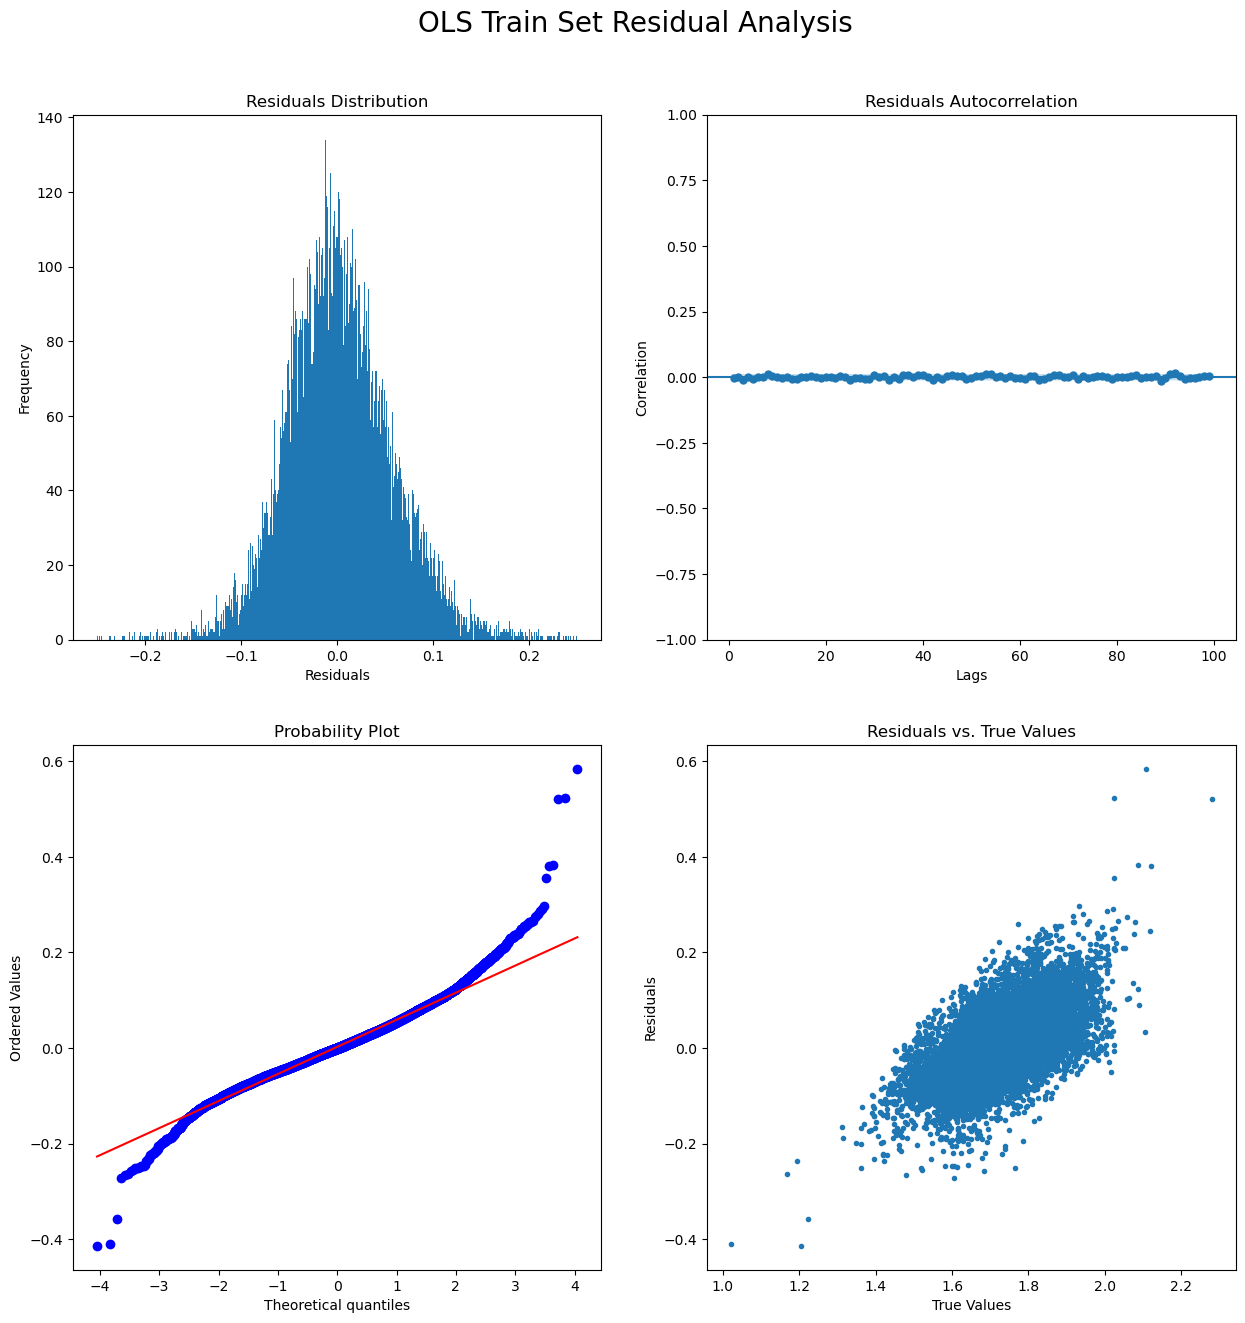

In [12]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('OLS Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.25,0.25))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [13]:
y_pred = np.exp(reg_model.predict(test))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.003143714735307435
RMSE Test Set =  0.05606883925414753
MAPE Test Set =  0.02507433734114213


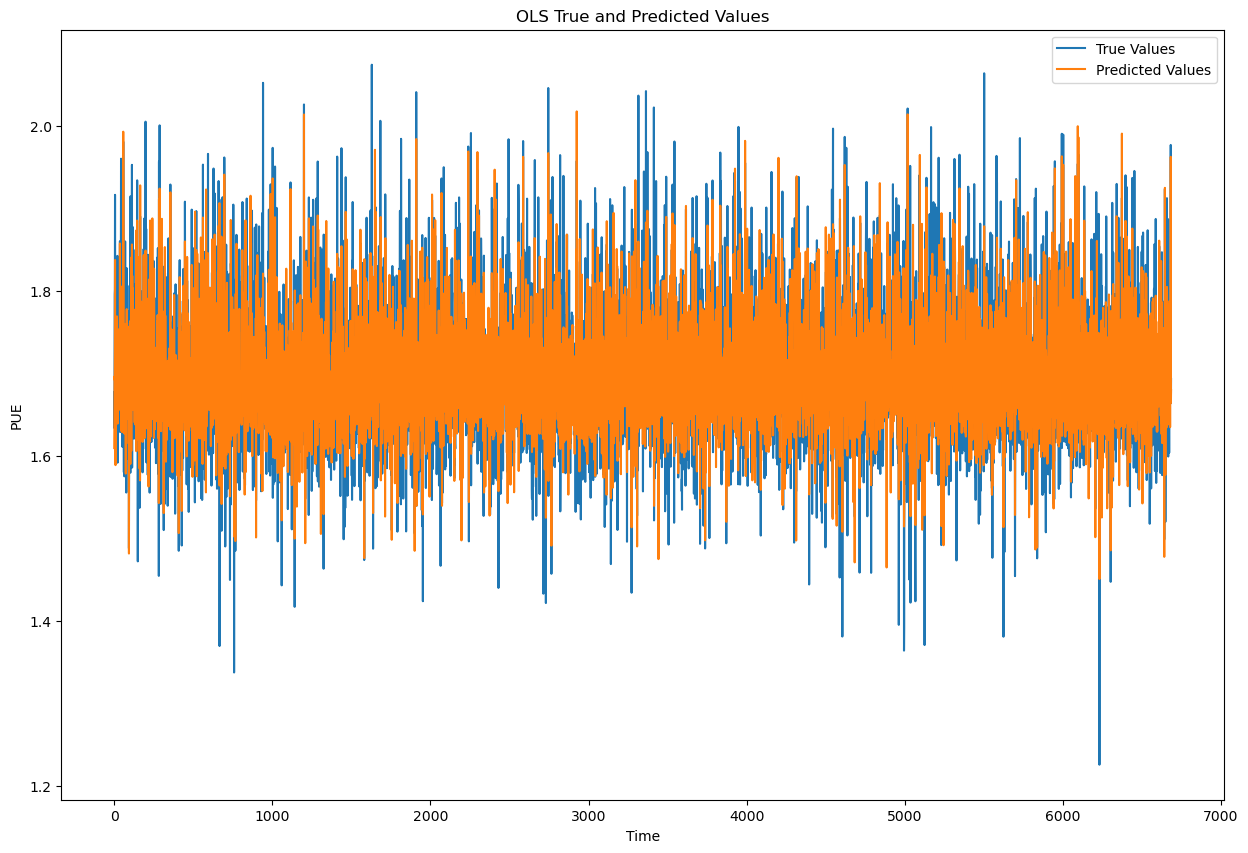

In [14]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(list(y_pred), label='Predicted Values')
plt.title('OLS True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

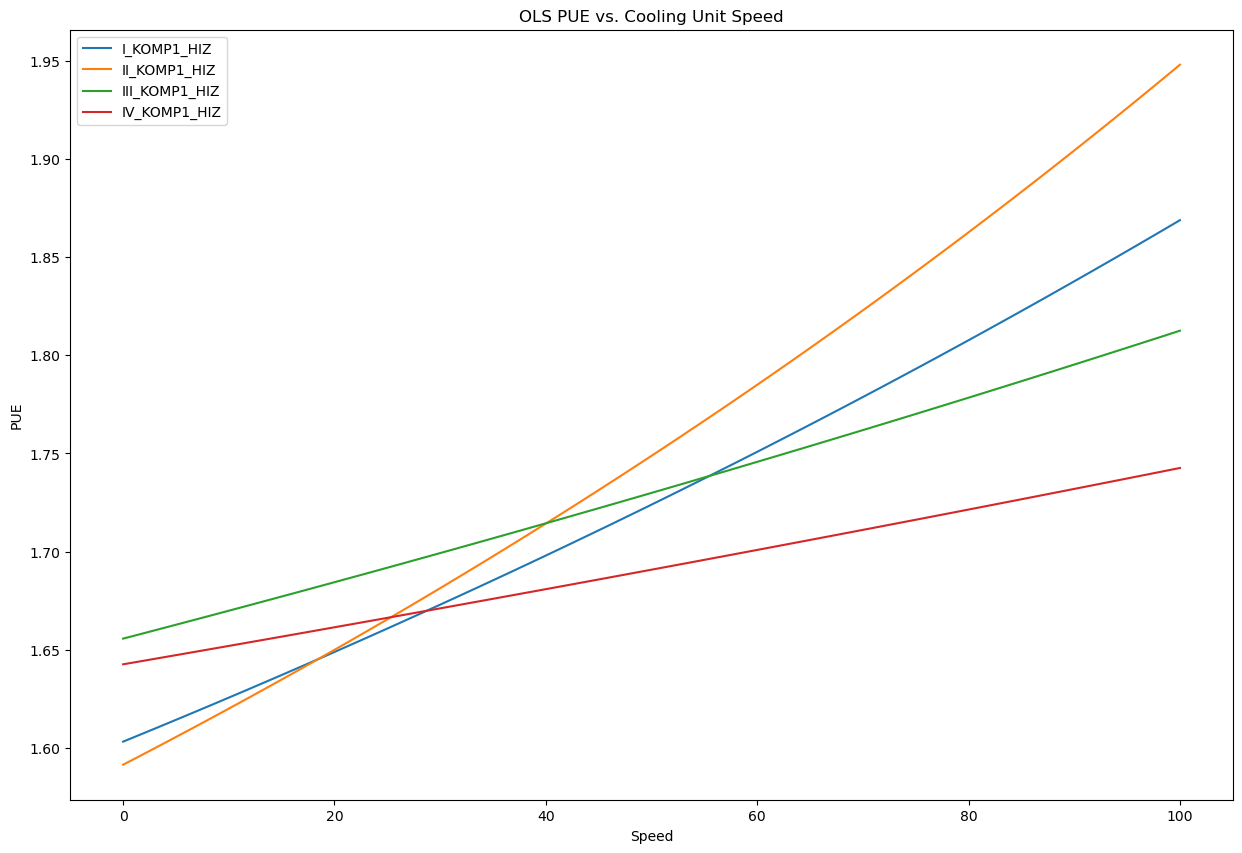

In [15]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[2][i] = y_pred


    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))+1
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('OLS PUE vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('PUE')
plt.legend()
plt.show()

## Random Forest

In [16]:
def random_forest(max_features):
    random_forest = RandomForestRegressor(random_state=23, max_features=max_features)
    result = random_forest.fit(train.iloc[:,2:], np.log(train.iloc[:,1]-1))
    return result

In [17]:
rf_model = random_forest(max_features='sqrt')

In [18]:
y_pred = np.exp(rf_model.predict(train.iloc[:,2:]))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.0002277503662888422
RMSE Train Set =  0.015091400408472443
MAPE Train Set =  0.0062643740486525296


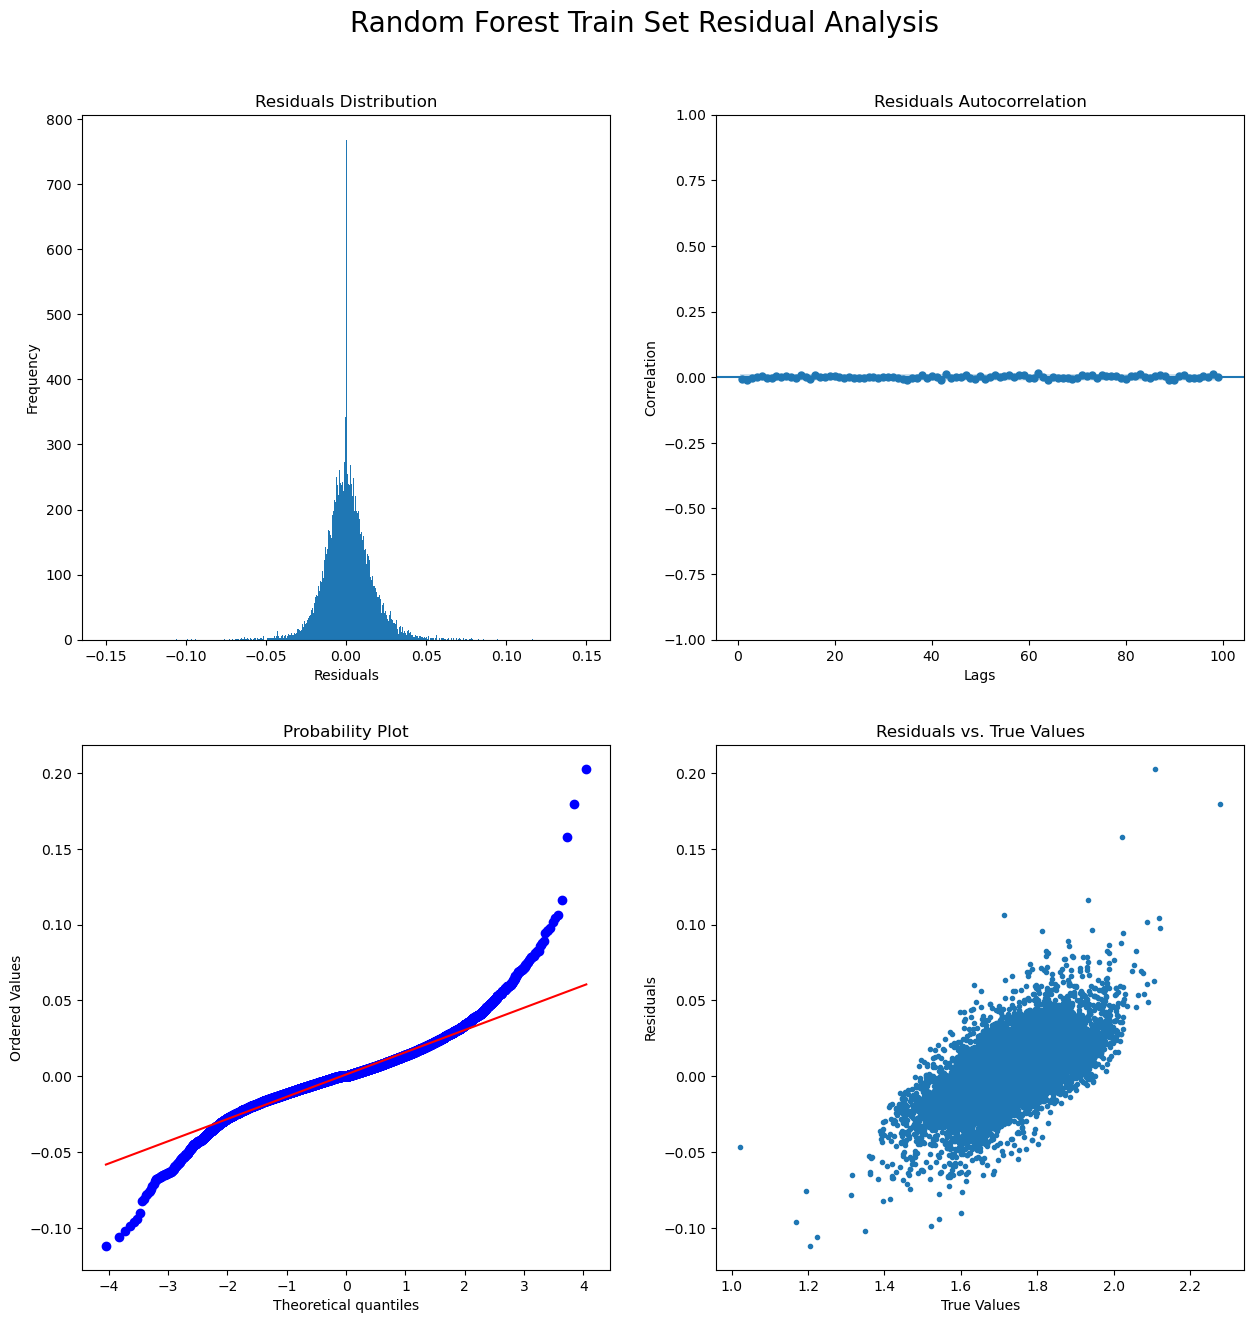

In [19]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Random Forest Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.15,0.15))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [20]:
y_pred = np.exp(rf_model.predict(test.iloc[:,2:]))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.0015279040753739918
RMSE Test Set =  0.039088413569419674
MAPE Test Set =  0.016571082351866977


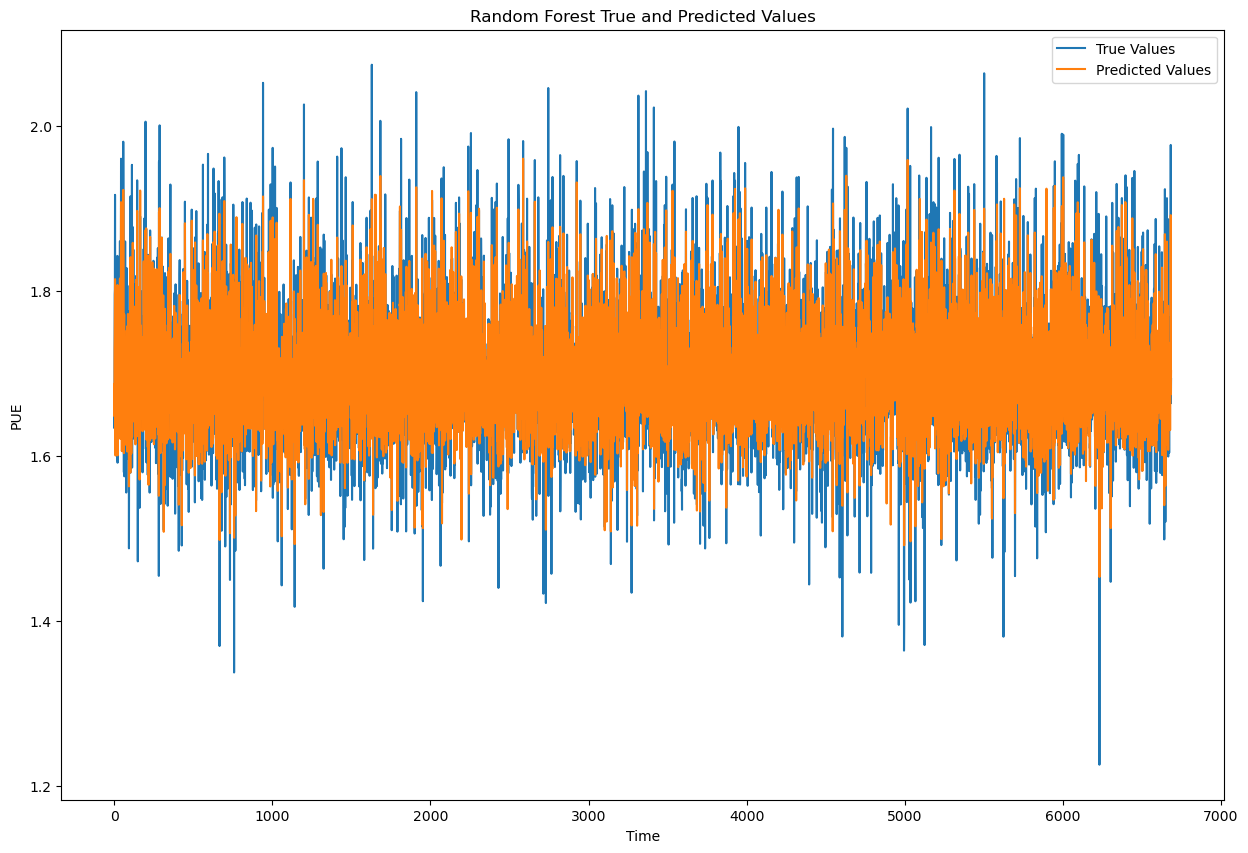

In [21]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Random Forest True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

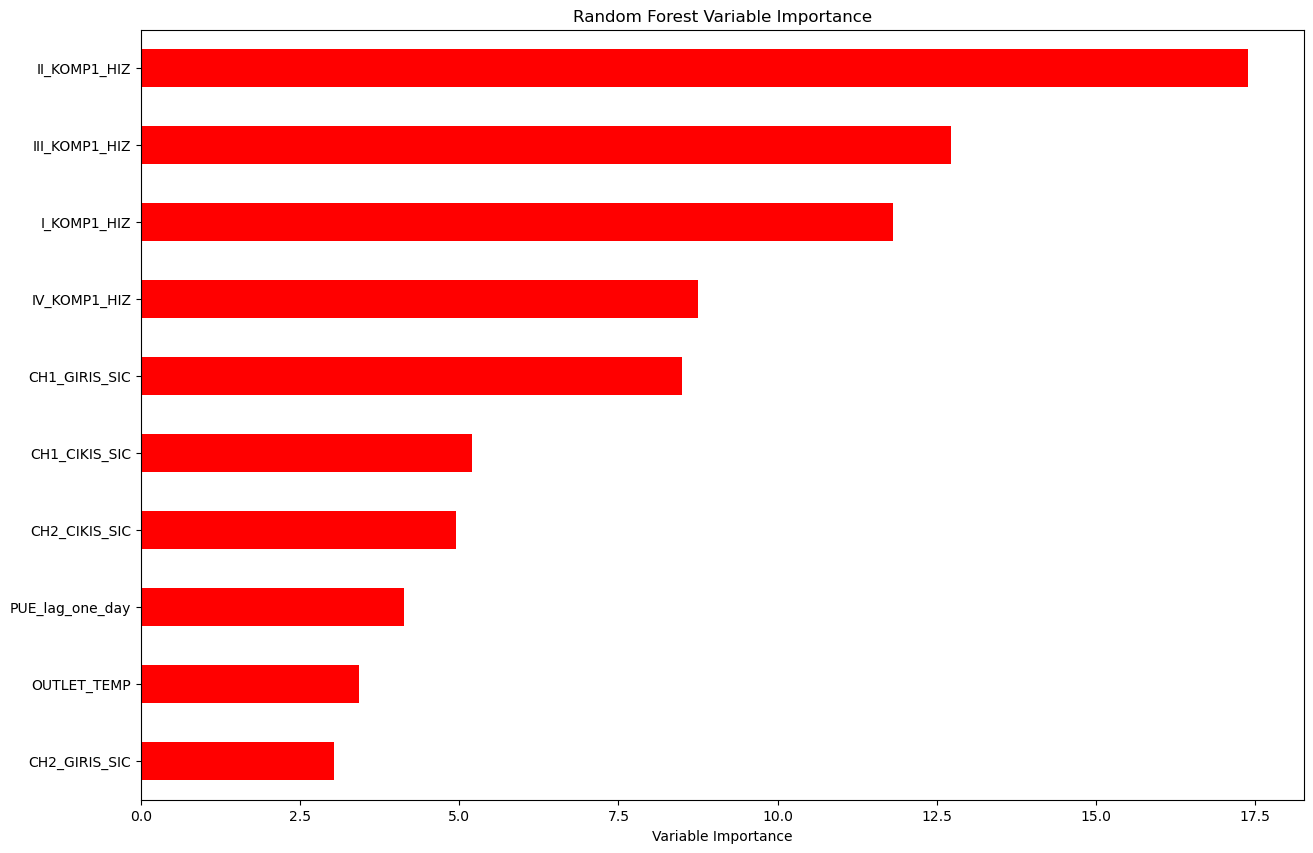

In [22]:
Importance = pd.DataFrame({'Importance':rf_model.feature_importances_*100}, 
                          )
Importance.index = train.iloc[:,2:].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(15, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Random Forest Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

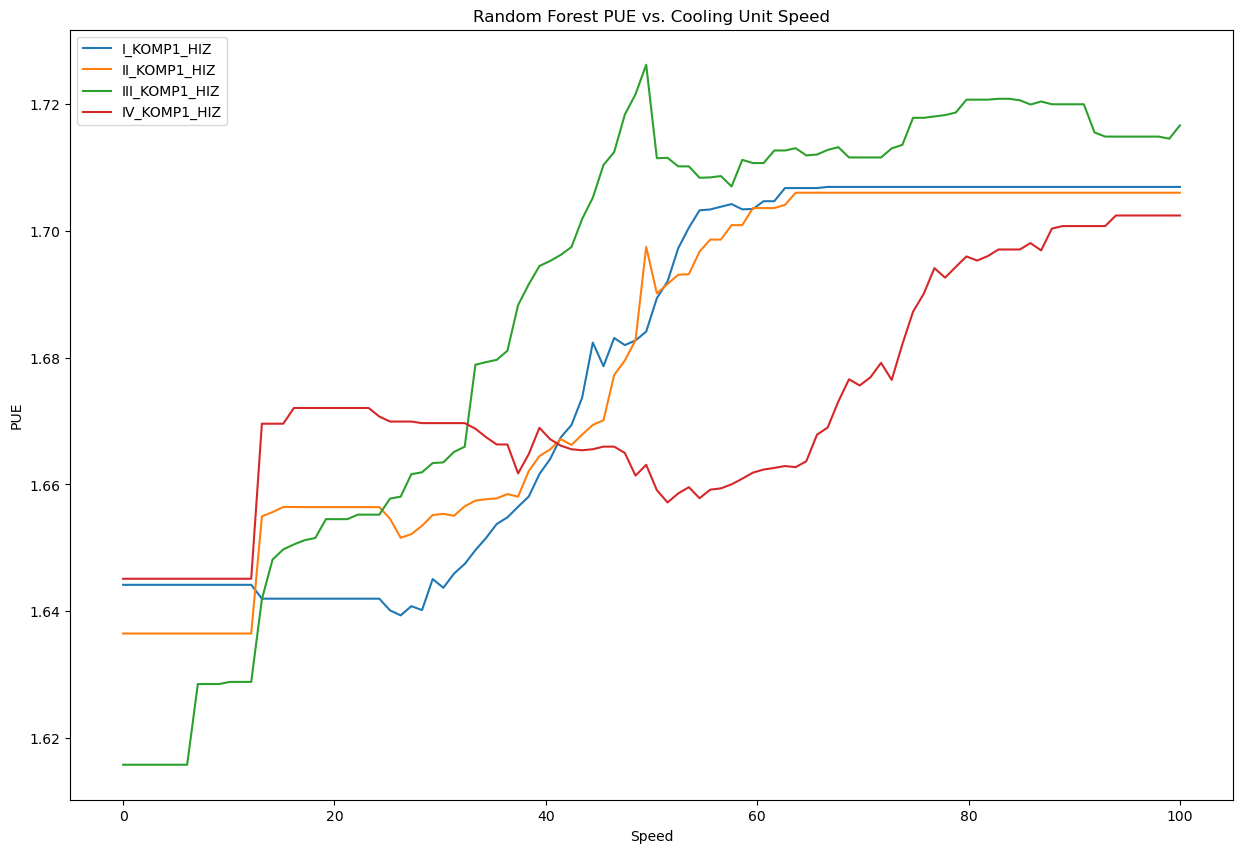

In [23]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.iloc[:,1:]))+1
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')

plt.title('Random Forest PUE vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('PUE')
plt.legend()
plt.show()

## Gradient Boosting

In [24]:
def gradient_boosting(depth, lr):
    gb = GradientBoostingRegressor(random_state=23, learning_rate=lr, max_depth=depth)
    result = gb.fit(train.iloc[:,2:], np.log(train.iloc[:,1]-1))
    return result

In [25]:
gb_model = gradient_boosting(lr=0.1, depth=5)

In [26]:
y_pred = np.exp(gb_model.predict(train.iloc[:,2:]))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.0010892391053943303
RMSE Train Set =  0.03300362261016706
MAPE Train Set =  0.014209918897702527


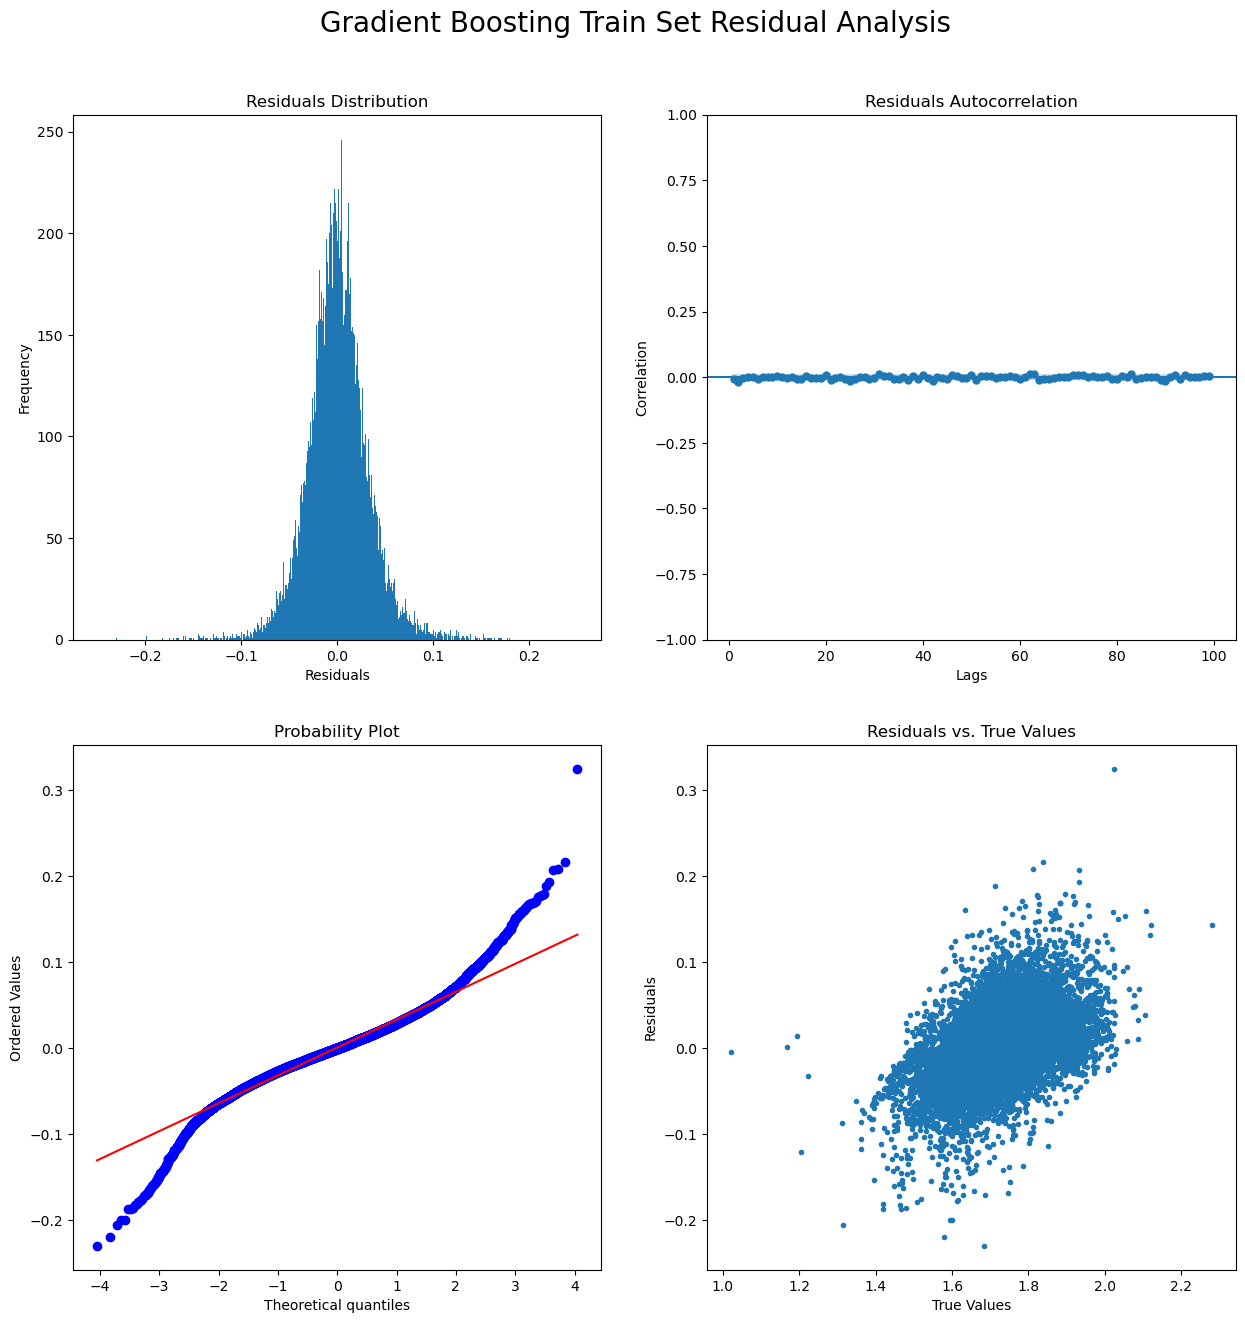

In [27]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Gradient Boosting Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.25,0.25))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [28]:
y_pred = np.exp(gb_model.predict(test.iloc[:,2:]))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.001272567288329079
RMSE Test Set =  0.035673061101187814
MAPE Test Set =  0.015156508750522433


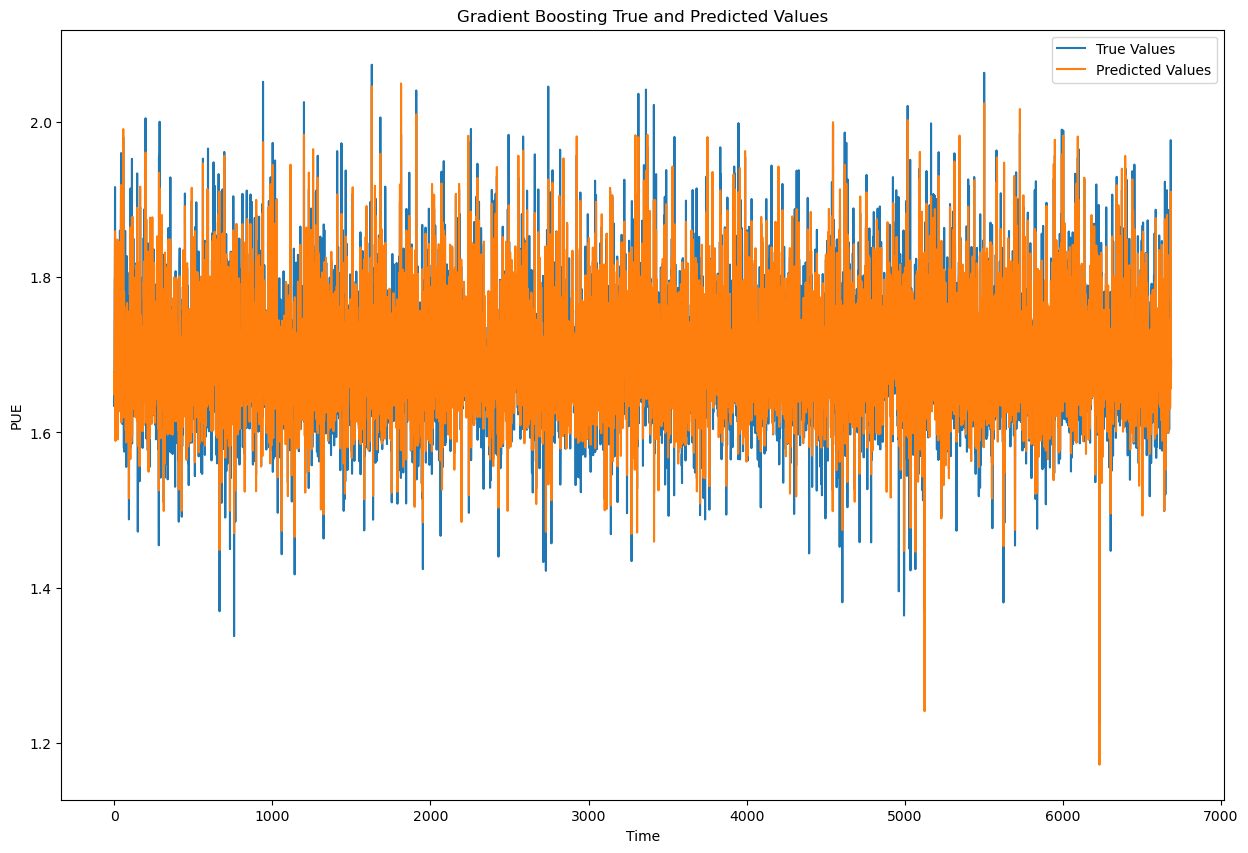

In [29]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Gradient Boosting True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

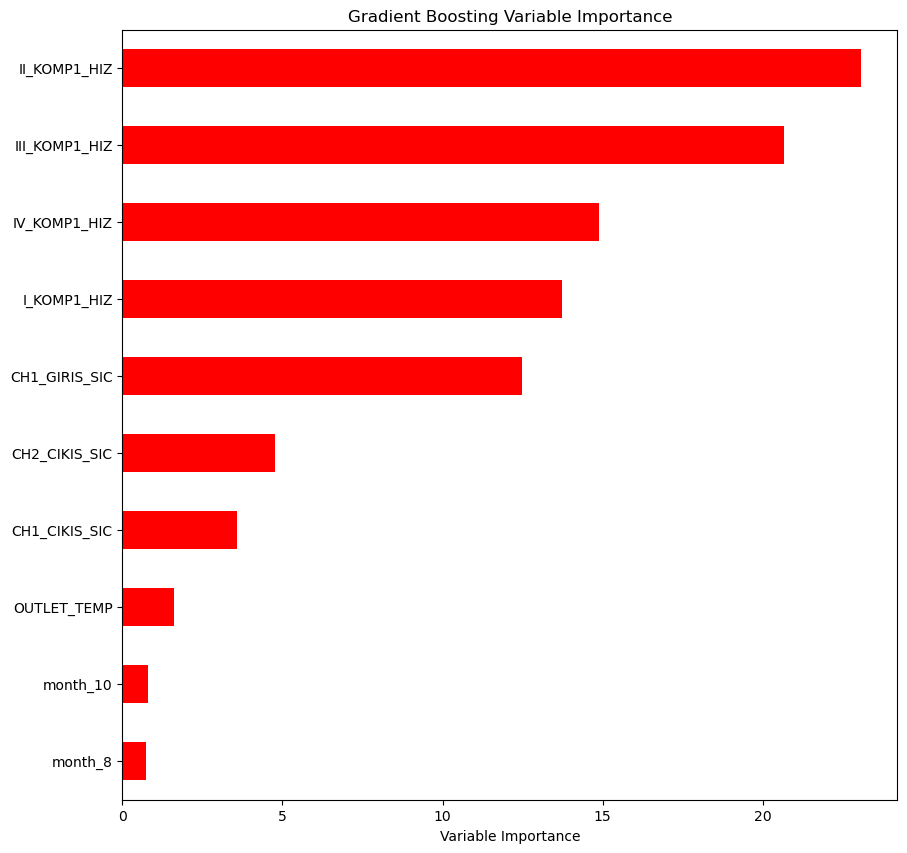

In [30]:
Importance = pd.DataFrame({'Importance':gb_model.feature_importances_*100}, 
                          )
Importance.index = train.iloc[:,2:].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(10, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Gradient Boosting Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

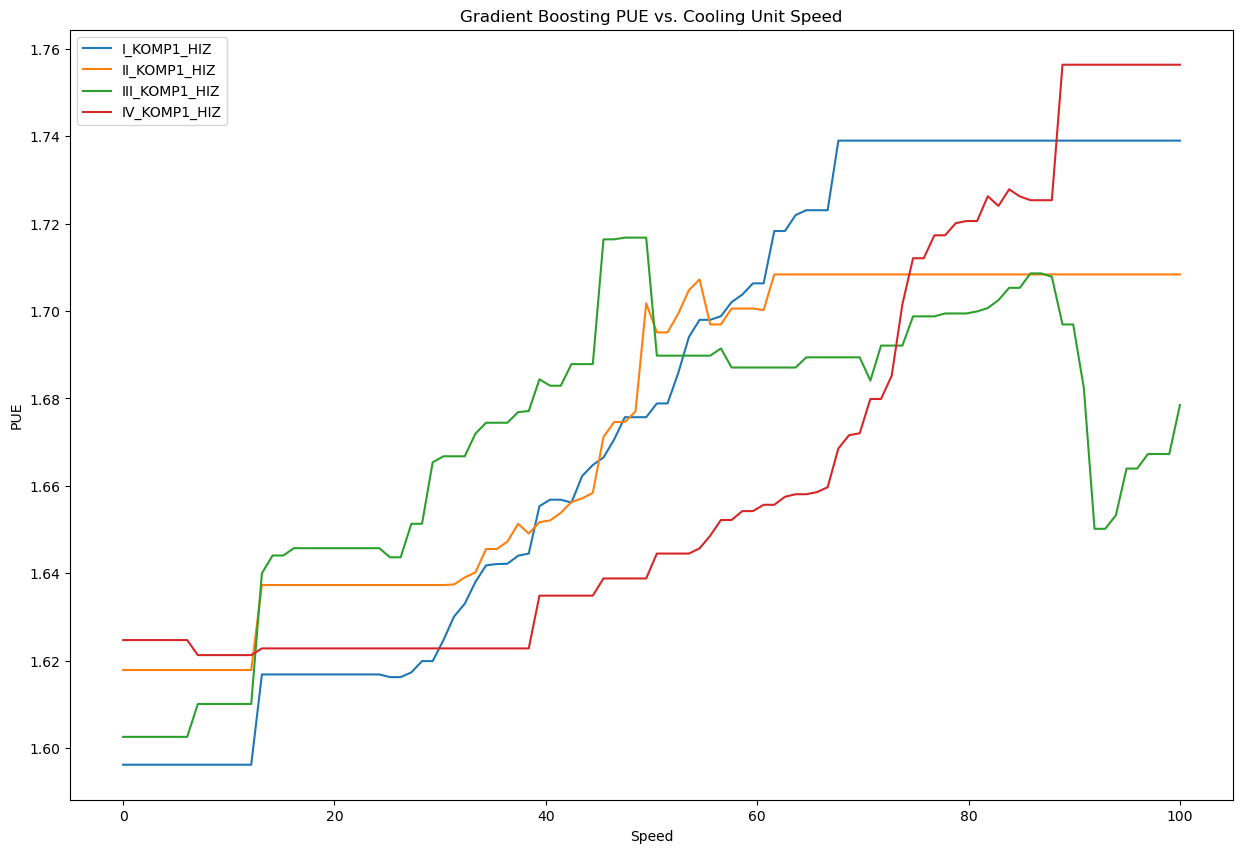

In [31]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.iloc[:,1:]))+1
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')

plt.title('Gradient Boosting PUE vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('PUE')
plt.legend()
plt.show()

## Lasso

In [99]:
def lasso(alpha):
    lasso_result = Lasso(normalize=True)
    lasso_result.set_params(alpha = alpha)
    result = lasso_result.fit(train.iloc[:,2:], np.log(train.iloc[:,1]-1))  
    coefs = lasso_result.coef_
    predictors = np.array((np.where(coefs != 0)[0]))
    return result, predictors

In [100]:
lasso_model, predictors = lasso(alpha=0.00002)

In [101]:
print(train.iloc[:,list(predictors+2)].columns)

Index(['I_KOMP1_HIZ', 'II_KOMP1_HIZ', 'III_KOMP1_HIZ', 'IV_KOMP1_HIZ',
       'CH1_CIKIS_SIC', 'CH1_GIRIS_SIC', 'CH2_CIKIS_SIC', 'CH2_GIRIS_SIC',
       'CH3_GIRIS_SIC', 'SENSOR_II_TEMP', 'month_8', 'month_9',
       'PUE_lag_one_day'],
      dtype='object')


In [102]:
y_pred = np.exp(lasso_model.predict(train.iloc[:,2:]))+1
y_true = train['PUE']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.0036041936660105105
RMSE Train Set =  0.06003493704511158
MAPE Train Set =  0.026904286148530132


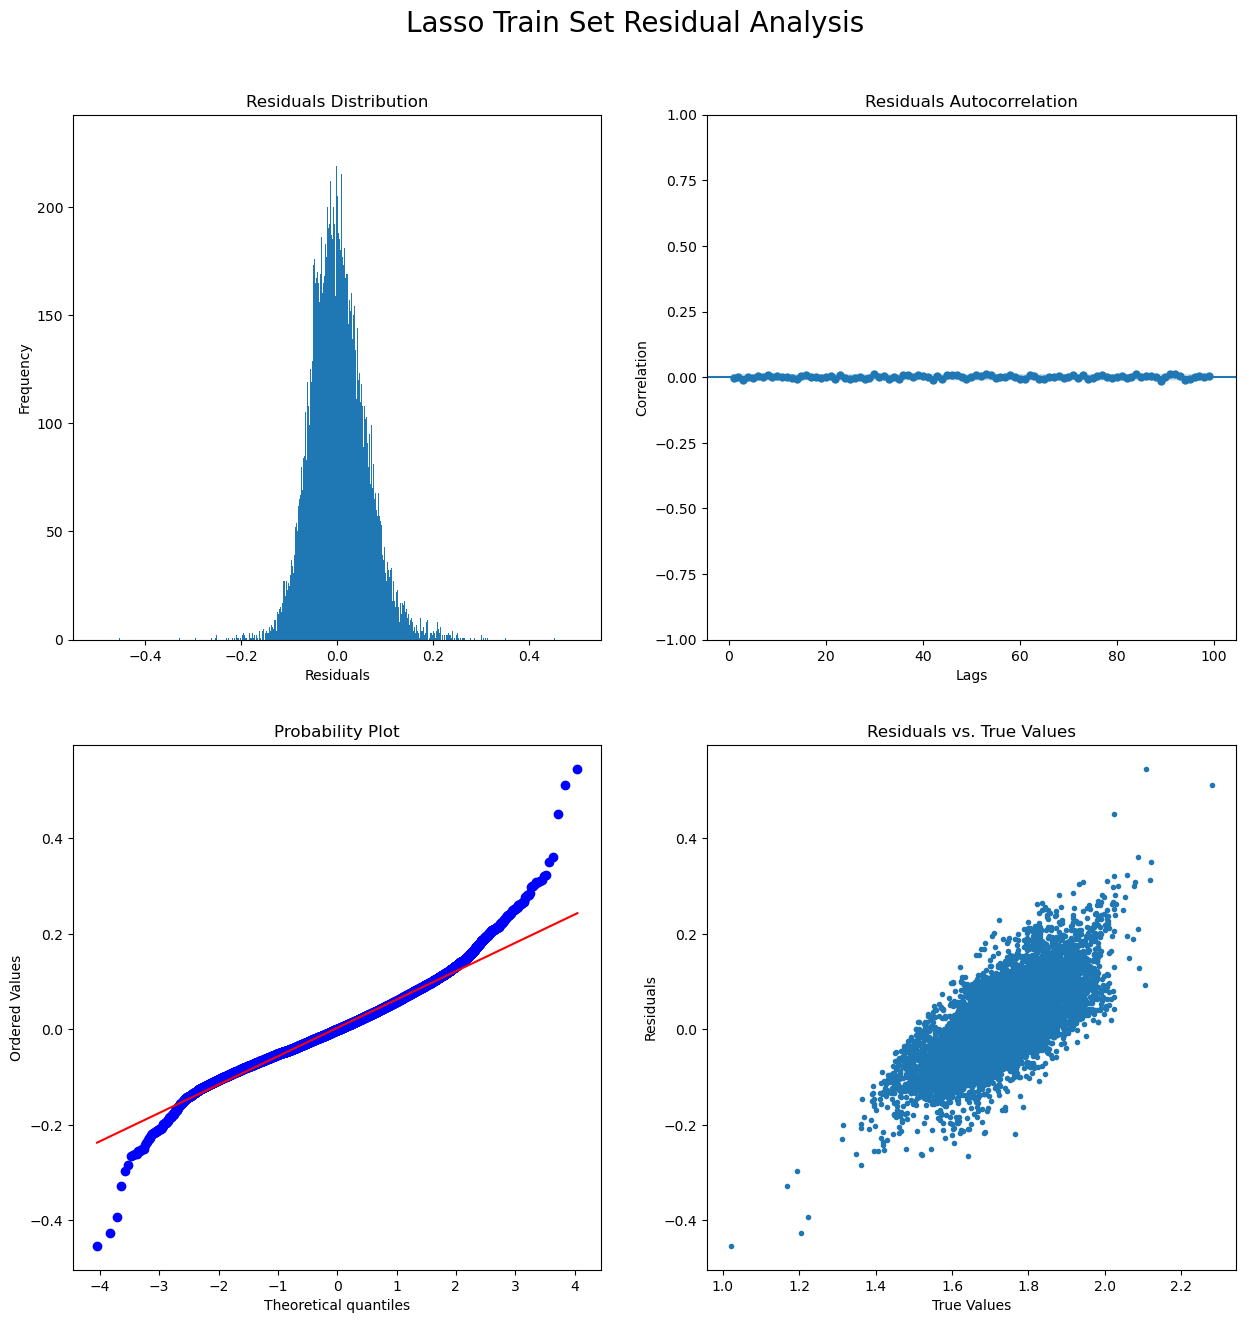

In [36]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Lasso Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.5,0.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [37]:
y_pred = np.exp(lasso_model.predict(test.iloc[:,2:]))+1
y_true = test['PUE']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.0035146659284561142
RMSE Test Set =  0.05928461797512163
MAPE Test Set =  0.026699867320950785


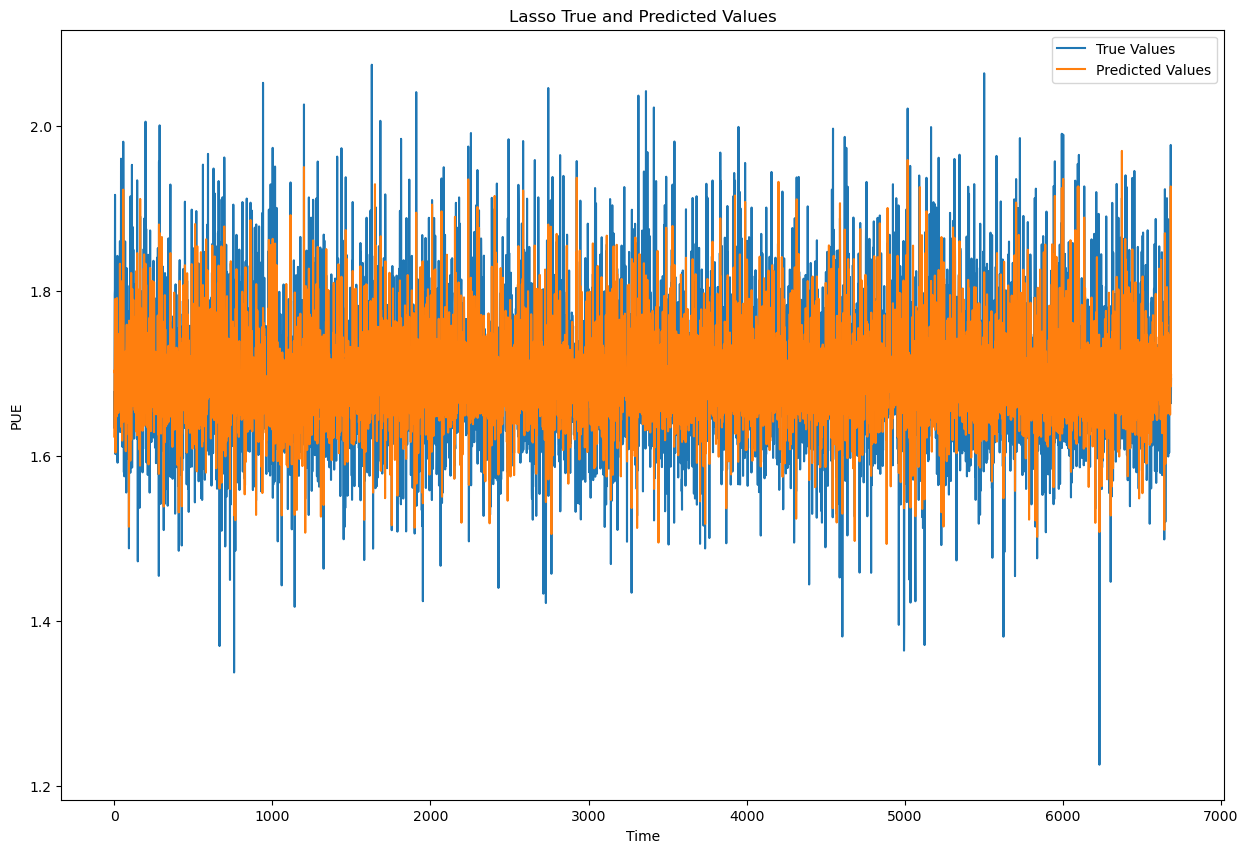

In [38]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Lasso True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('PUE')
plt.legend()
plt.show()

# Sensor-I Temperature Predictions

## OLS

In [39]:
formula_x1 = "np.log(SENSOR_I_TEMP)"
formula_x2 = "np.log(SENSOR_II_TEMP)"
formula_y = ""
for i in range(2, len(FINAL_DF.columns)):
    if FINAL_DF.columns[i] != 'SENSOR_I_TEMP' and FINAL_DF.columns[i] != 'SENSOR_II_TEMP' and FINAL_DF.columns[i] != 'PUE_lag_one_day':
        formula_y += FINAL_DF.columns[i] + " + "

formula_y = formula_y[:-3]

formula1 = formula_x1 + " ~ " + formula_y
formula2 = formula_x2 + " ~ " + formula_y
print(formula1)
print(formula2)

np.log(SENSOR_I_TEMP) ~ I_KOMP1_HIZ + II_KOMP1_HIZ + III_KOMP1_HIZ + IV_KOMP1_HIZ + CH1_CIKIS_SIC + CH1_GIRIS_SIC + CH2_CIKIS_SIC + CH2_GIRIS_SIC + CH3_CIKIS_SIC + CH3_GIRIS_SIC + OUTLET_TEMP + OUTLET_HUMIDITY + Mon + Tue + Wed + Thu + Fri + Sat + hour_0 + hour_1 + hour_2 + hour_3 + hour_4 + hour_5 + hour_6 + hour_7 + hour_8 + hour_9 + hour_10 + hour_11 + hour_12 + hour_13 + hour_14 + hour_15 + hour_16 + hour_17 + hour_18 + hour_19 + hour_20 + hour_21 + hour_22 + hour_23 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10
np.log(SENSOR_II_TEMP) ~ I_KOMP1_HIZ + II_KOMP1_HIZ + III_KOMP1_HIZ + IV_KOMP1_HIZ + CH1_CIKIS_SIC + CH1_GIRIS_SIC + CH2_CIKIS_SIC + CH2_GIRIS_SIC + CH3_CIKIS_SIC + CH3_GIRIS_SIC + OUTLET_TEMP + OUTLET_HUMIDITY + Mon + Tue + Wed + Thu + Fri + Sat + hour_0 + hour_1 + hour_2 + hour_3 + hour_4 + hour_5 + hour_6 + hour_7 + hour_8 + hour_9 + hour_10 + hour_11 + hour_12 + hour_13 + hour_14 + hour_15 + hour_16 + hour_17 + hour_18 + hour_19 + hour_20 + hour

In [40]:
reg_model = sm.ols(formula=formula1, data=train).fit()
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(SENSOR_I_TEMP)   R-squared:                       0.598
Model:                               OLS   Adj. R-squared:                  0.598
Method:                    Least Squares   F-statistic:                     904.1
Date:                   Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                           16:50:55   Log-Likelihood:                 51711.
No. Observations:                  26737   AIC:                        -1.033e+05
Df Residuals:                      26692   BIC:                        -1.030e+05
Df Model:                             44                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.7190      0.014    199.306      0.000       2.692       2.746
I_KOMP1_HIZ         0.0002   2.09e-05      7.847      0.000       0.000       0.000
II_KOMP1_HIZ       -0.0002   1.74e-05    -10.450      0.000      -0.000      -0.000
III_KOMP1_HIZ   -6.594e-05   1.26e-05     -5.245      0.000   -9.06e-05   -4.13e-05
IV_KOMP1_HIZ        0.0003   1.83e-05     15.848      0.000       0.000       0.000
CH1_CIKIS_SIC      -0.0064      0.000    -22.200      0.000      -0.007      -0.006
CH1_GIRIS_SIC       0.0008      0.000      2.983      0.003       0.000       0.001
CH2_CIKIS_SIC       0.0020      0.000     17.601      0.000       0.002       0.002
CH2_GIRIS_SIC      -0.0001   2.34e-05     -4.460      0.000      -0.000   -5.86e-05
CH3_CIKIS_SIC      -0.0365      0.000   -121.678      0.000      -0.037      -0.036
CH3_GIRIS_SIC       0.0505      0.001     87.463      0.000       0.049       0.052
OUTLET_TEMP        -0.0030   8.96e-05    -33.659      0.000      -0.003      -0.003
OUTLET_HUMIDITY -8.259e-05   2.37e-05     -3.484      0.000      -0.000   -3.61e-05
Mon                 0.0067      0.001     11.869      0.000       0.006       0.008
Tue                -0.0013      0.001     -2.376      0.018      -0.002      -0.000
Wed                -0.0035      0.001     -6.064      0.000      -0.005      -0.002
Thu                -0.0053      0.001     -9.129      0.000      -0.006      -0.004
Fri                -0.0031      0.001     -5.488      0.000      -0.004      -0.002
Sat                -0.0028      0.001     -4.970      0.000      -0.004      -0.002
hour_0              0.0011      0.001      0.932      0.351      -0.001       0.003
hour_1              0.0020      0.001      1.678      0.093      -0.000       0.004
hour_2              0.0008      0.001      0.661      0.509      -0.002       0.003
hour_3             -0.0011      0.001     -0.900      0.368      -0.003       0.001
hour_4             -0.0016      0.001     -1.370      0.171      -0.004       0.001
hour_5             -0.0004      0.001     -0.387      0.699      -0.003       0.002
hour_6             -0.0011      0.001     -0.928      0.354      -0.003       0.001
hour_7             -0.0021      0.001     -1.894      0.058      -0.004    7.45e-05
hour_8             -0.0002      0.001     -0.144      0.886      -0.002       0.002
hour_9             -0.0019      0.001     -1.653      0.098      -0.004       0.000
hour_10            -0.0021      0.001     -1.701      0.089      -0.004       0.000
hour_11            -0.0033      0.001     -2.738      0.006      -0.006      -0.001
hour_12            -0.0030      0.001     -2.481      0.013      -0.005      -0.001
hour_13            -0.0011      0.001     -0.916      0.360      -0.004       0.001
hour_14             0.0005

In [41]:
y_pred = np.exp(reg_model.predict(train))
y_true = train['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.3439192545546499
RMSE Train Set =  0.5864462929839781
MAPE Train Set =  0.028289199653726435


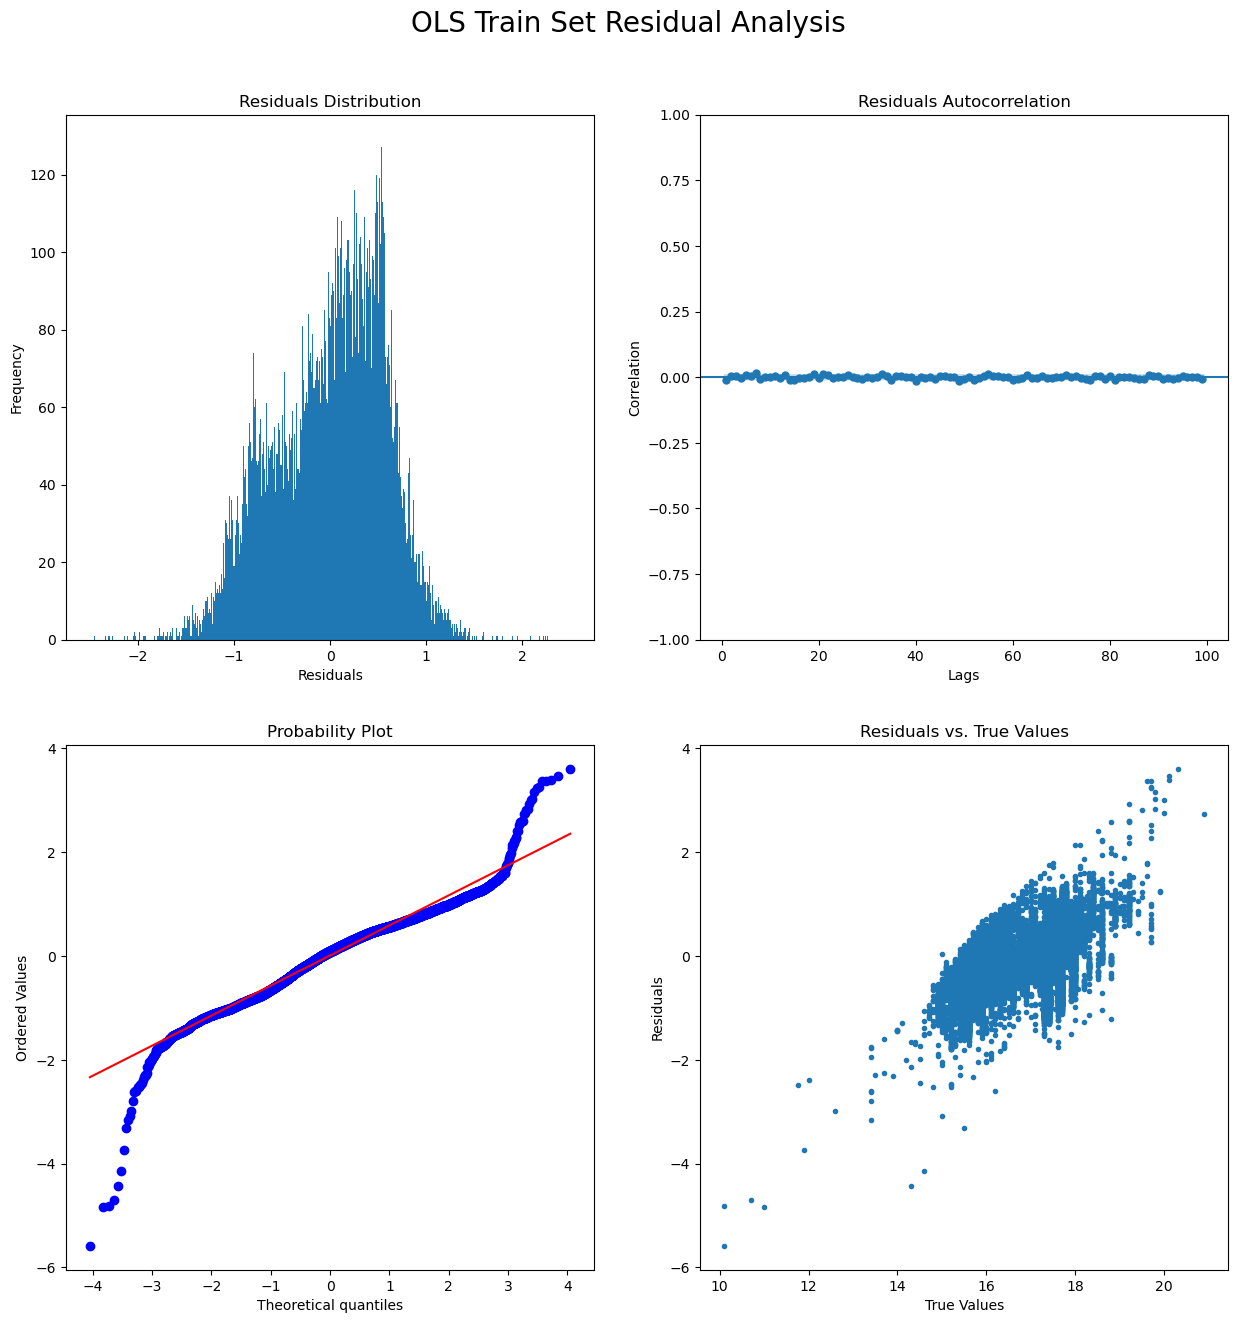

In [42]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('OLS Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-2.5,2.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [43]:
y_pred = np.exp(reg_model.predict(test))
y_true = test['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.34635370118859
RMSE Test Set =  0.5885182250267106
MAPE Test Set =  0.028293215569728275


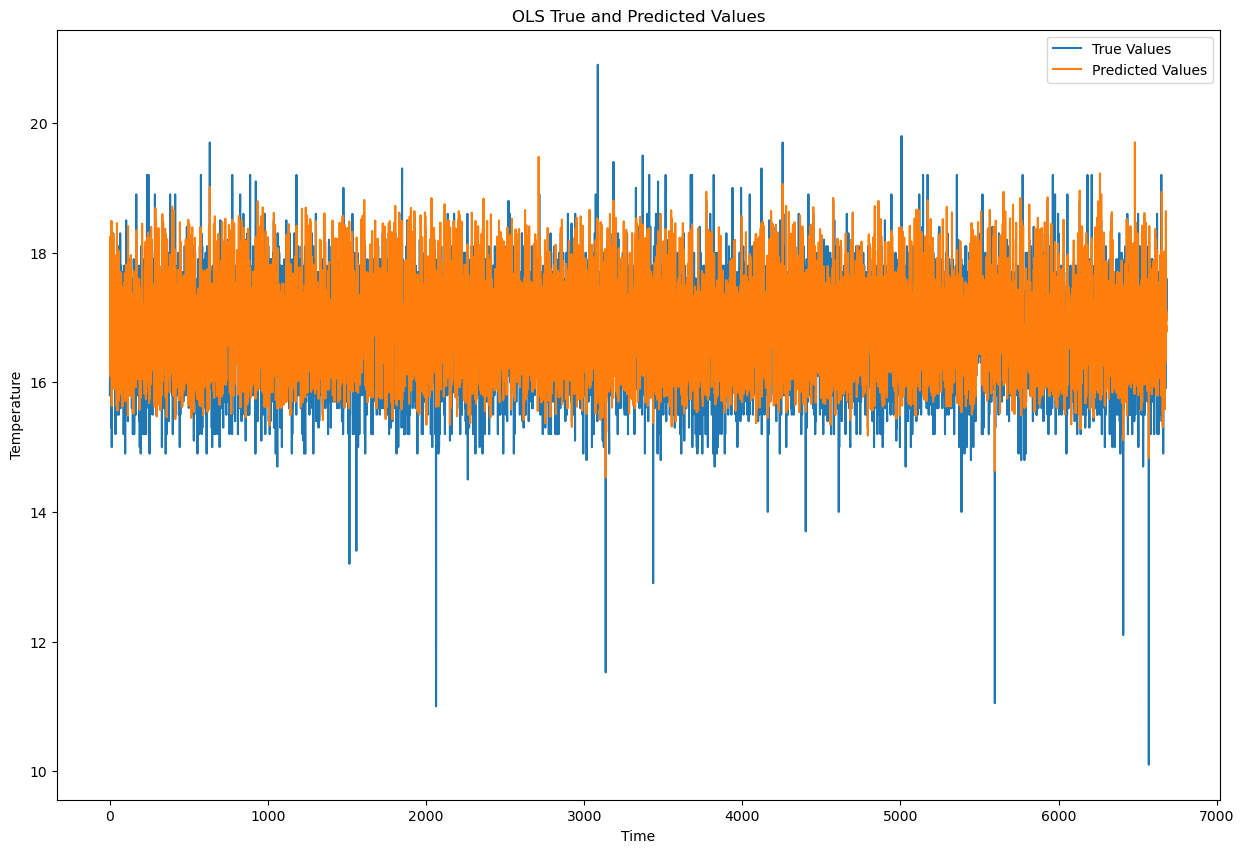

In [44]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(list(y_pred), label='Predicted Values')
plt.title('OLS True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

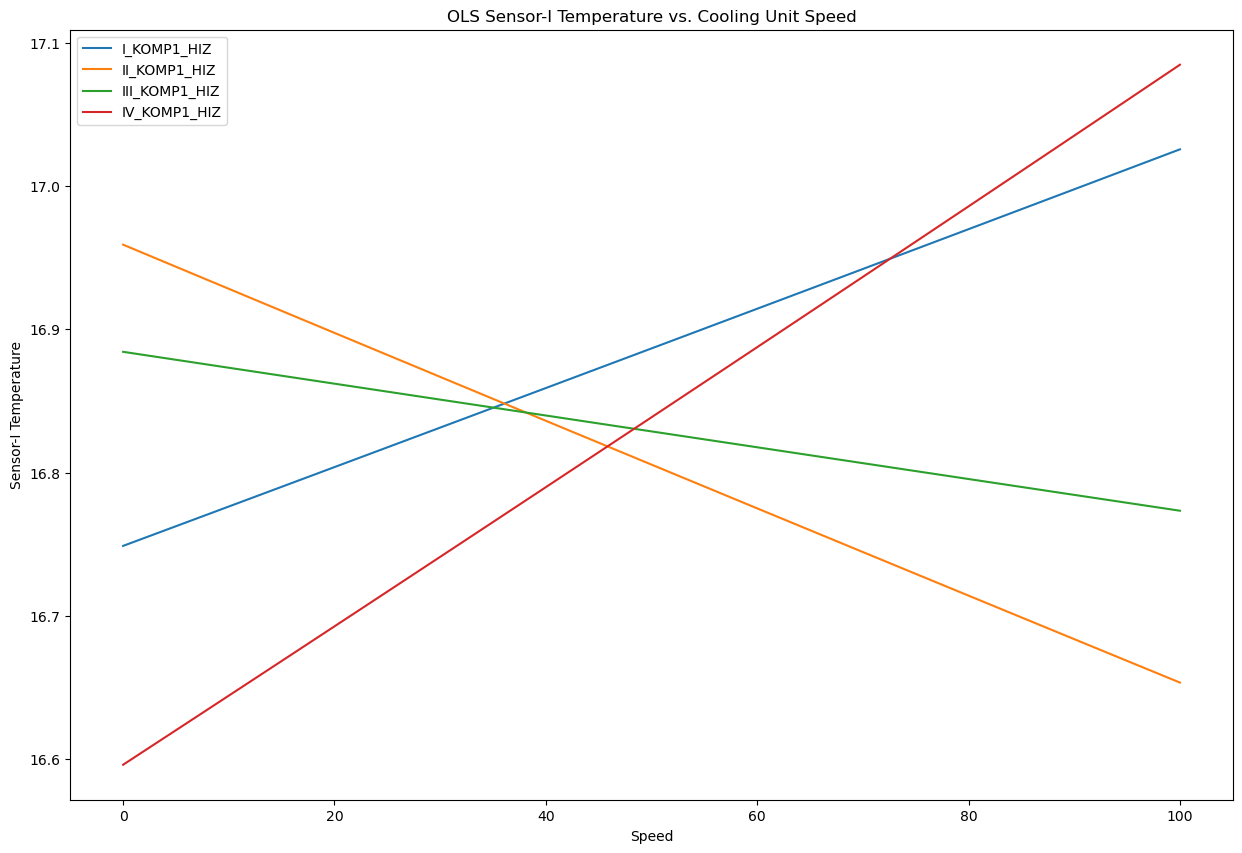

In [45]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')

plt.title('OLS Sensor-I Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-I Temperature')
plt.legend()
plt.show()

## Random Forest

In [46]:
def random_forest(max_features):
    random_forest = RandomForestRegressor(random_state=23, max_features=max_features)
    result = random_forest.fit(train.loc[:,formula_y.split(' + ')], np.log(train.loc[:,"SENSOR_I_TEMP"]))
    return result

In [47]:
rf_model = random_forest(max_features='sqrt')

In [48]:
y_pred = np.exp(rf_model.predict(train.loc[:,formula_y.split(' + ')]))
y_true = train['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.009202166859904085
RMSE Train Set =  0.09592792533930923
MAPE Train Set =  0.0032549297005569225


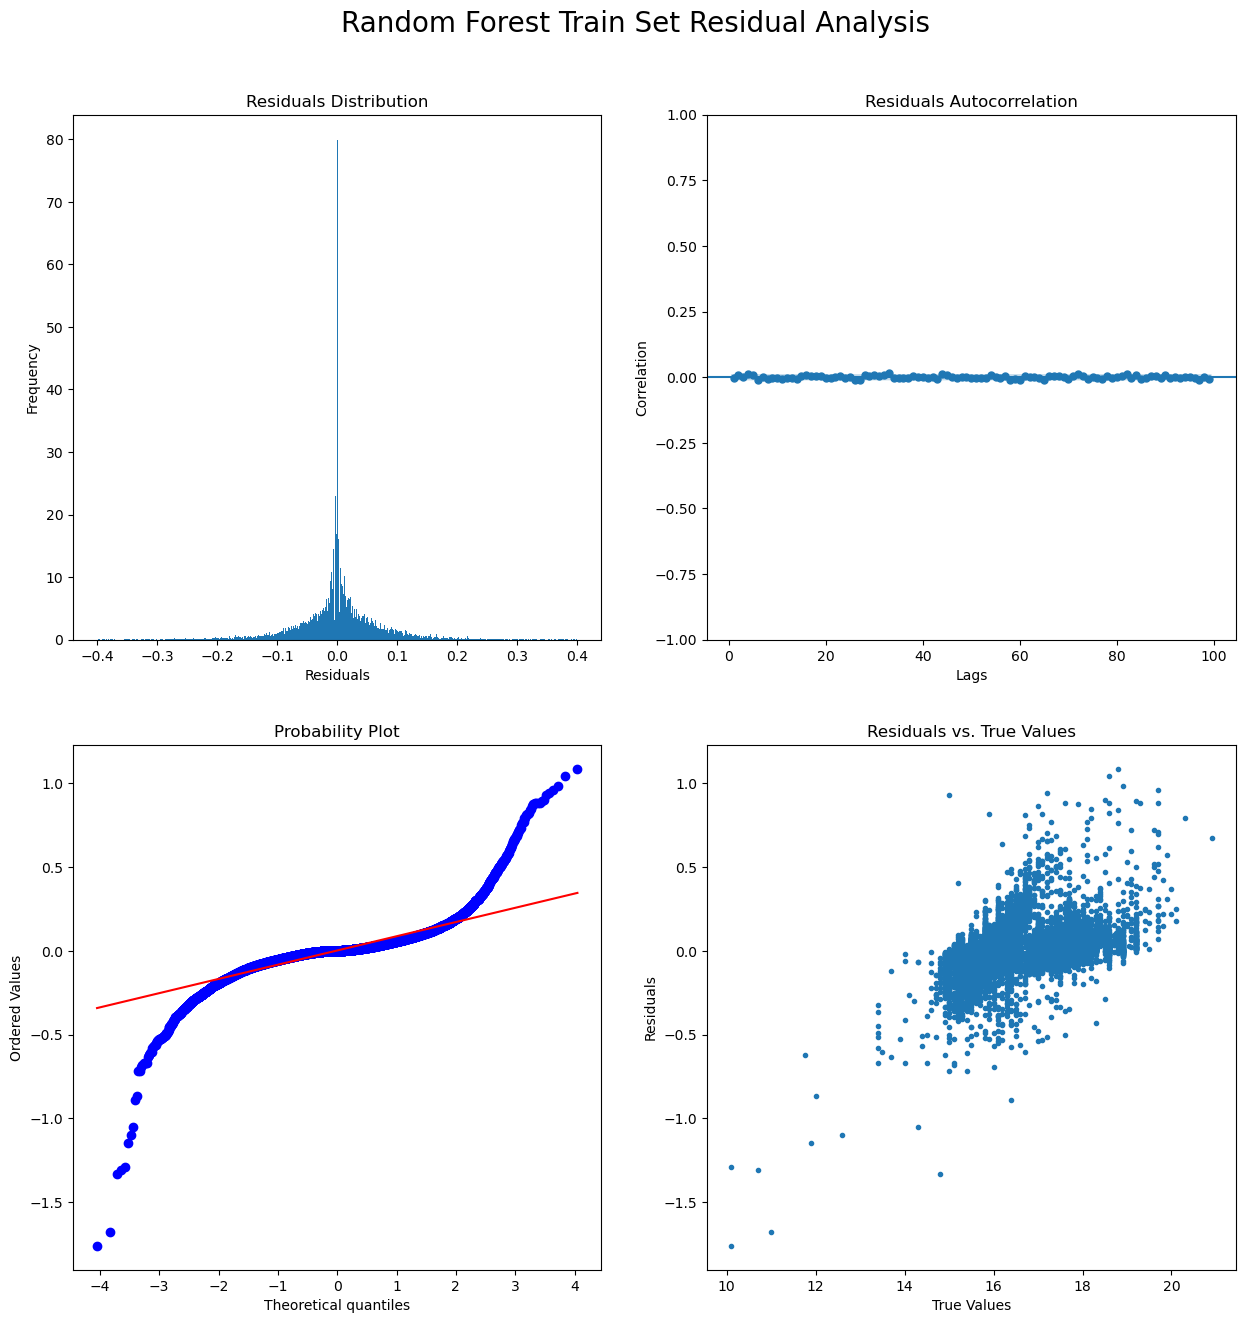

In [49]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Random Forest Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.4,0.4), density=True)
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [50]:
y_pred = np.exp(rf_model.predict(test.loc[:,formula_y.split(' + ')]))
y_true = test['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.06691312819792063
RMSE Test Set =  0.25867572015541124
MAPE Test Set =  0.008759133094501


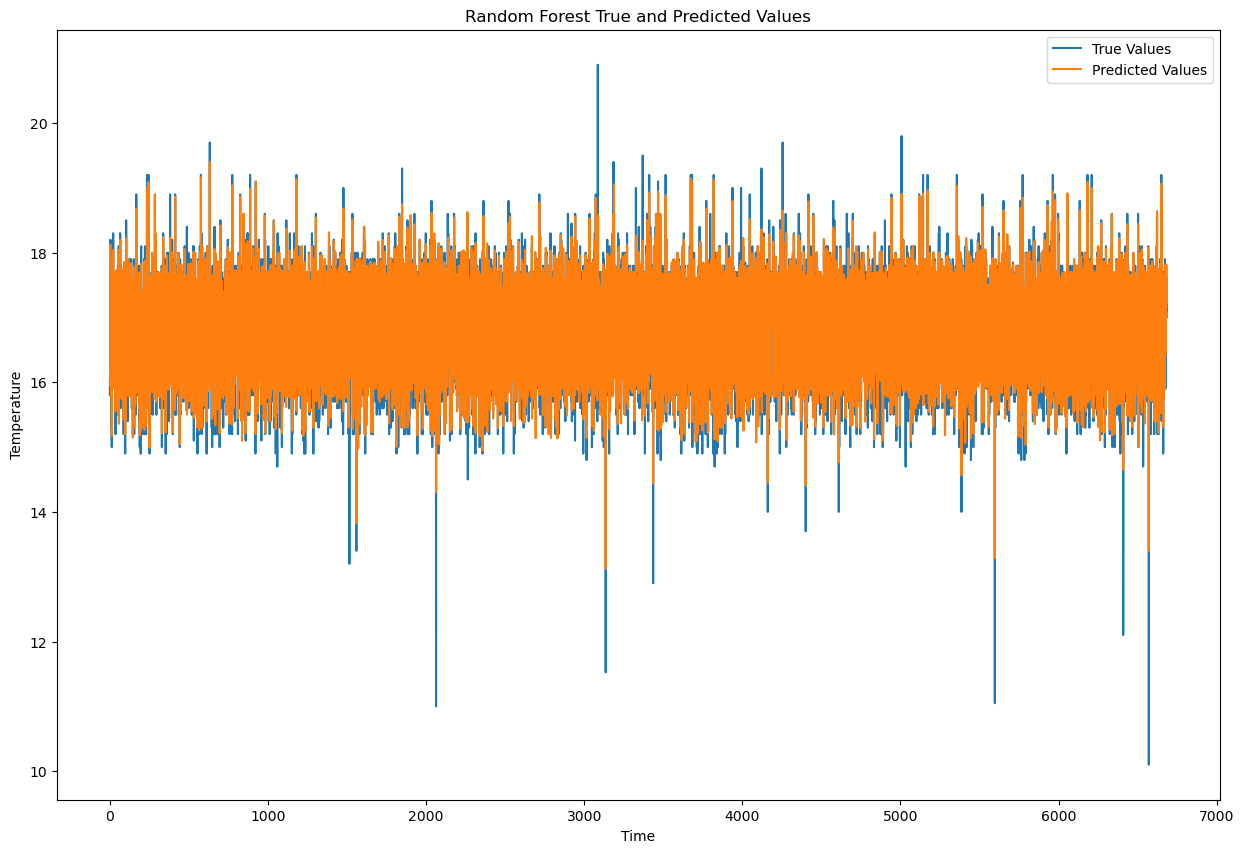

In [51]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Random Forest True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

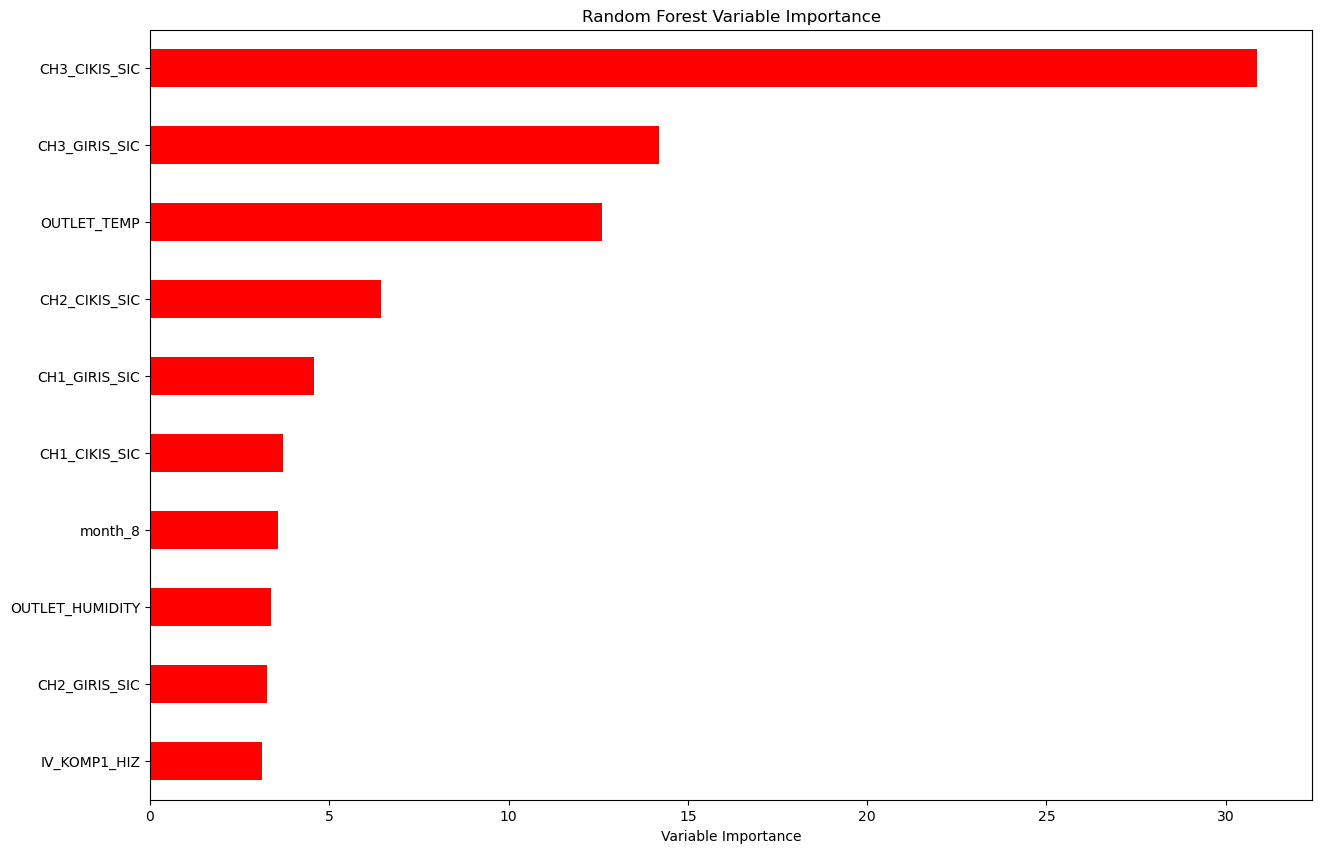

In [52]:
Importance = pd.DataFrame({'Importance':rf_model.feature_importances_*100}, 
                          )
Importance.index = train.loc[:,formula_y.split(' + ')].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(15, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Random Forest Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

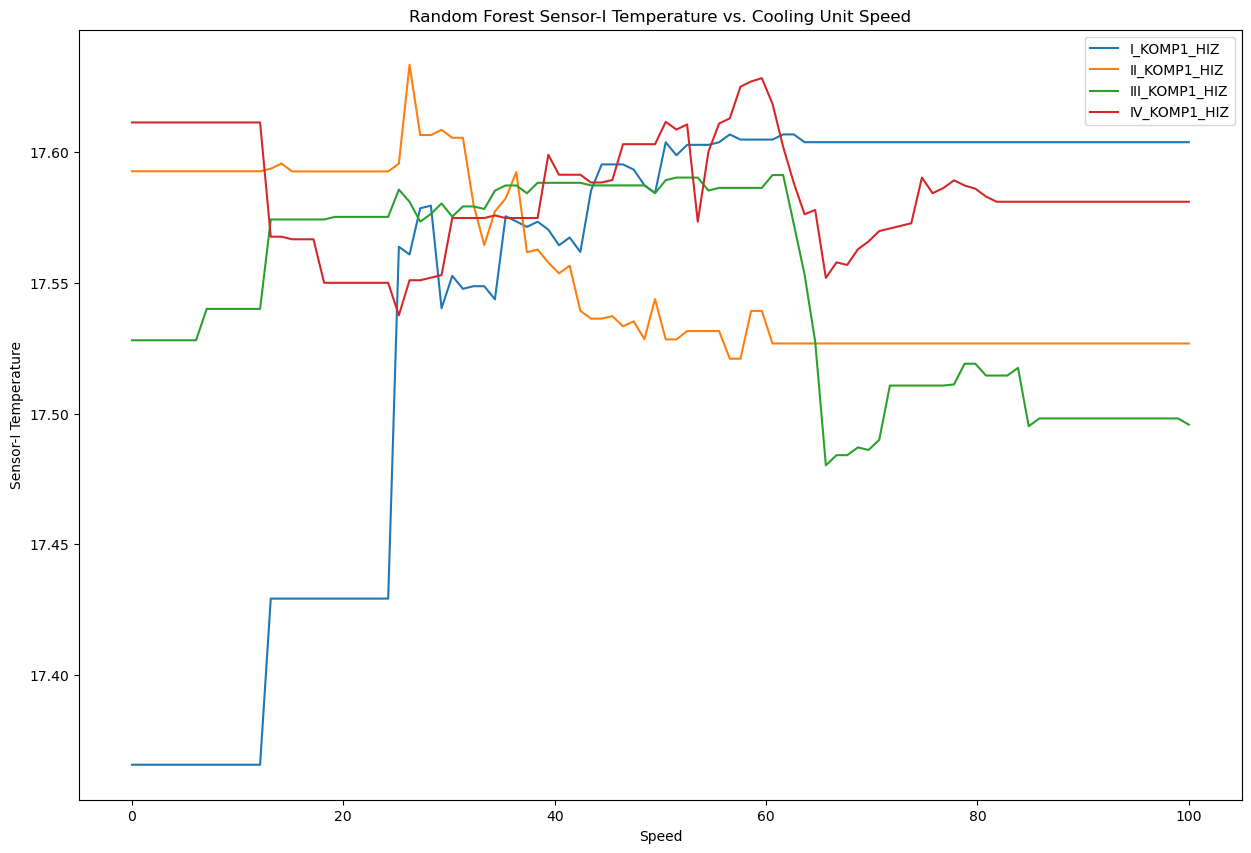

In [53]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[3][i] = y_pred
        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')

plt.title('Random Forest Sensor-I Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-I Temperature')
plt.legend()
plt.show()

## Gradient Boosting

In [54]:
def gradient_boosting(depth, lr):
    gb = GradientBoostingRegressor(random_state=23, learning_rate=lr, max_depth=depth)
    result = gb.fit(train.loc[:,formula_y.split(' + ')], np.log(train.loc[:,"SENSOR_I_TEMP"]))
    return result

In [55]:
gb_model = gradient_boosting(lr=0.1, depth=5)

In [56]:
y_pred = np.exp(gb_model.predict(train.loc[:,formula_y.split(' + ')]))
y_true = train['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.06474908969053945
RMSE Train Set =  0.254458424286836
MAPE Train Set =  0.009697195765452317


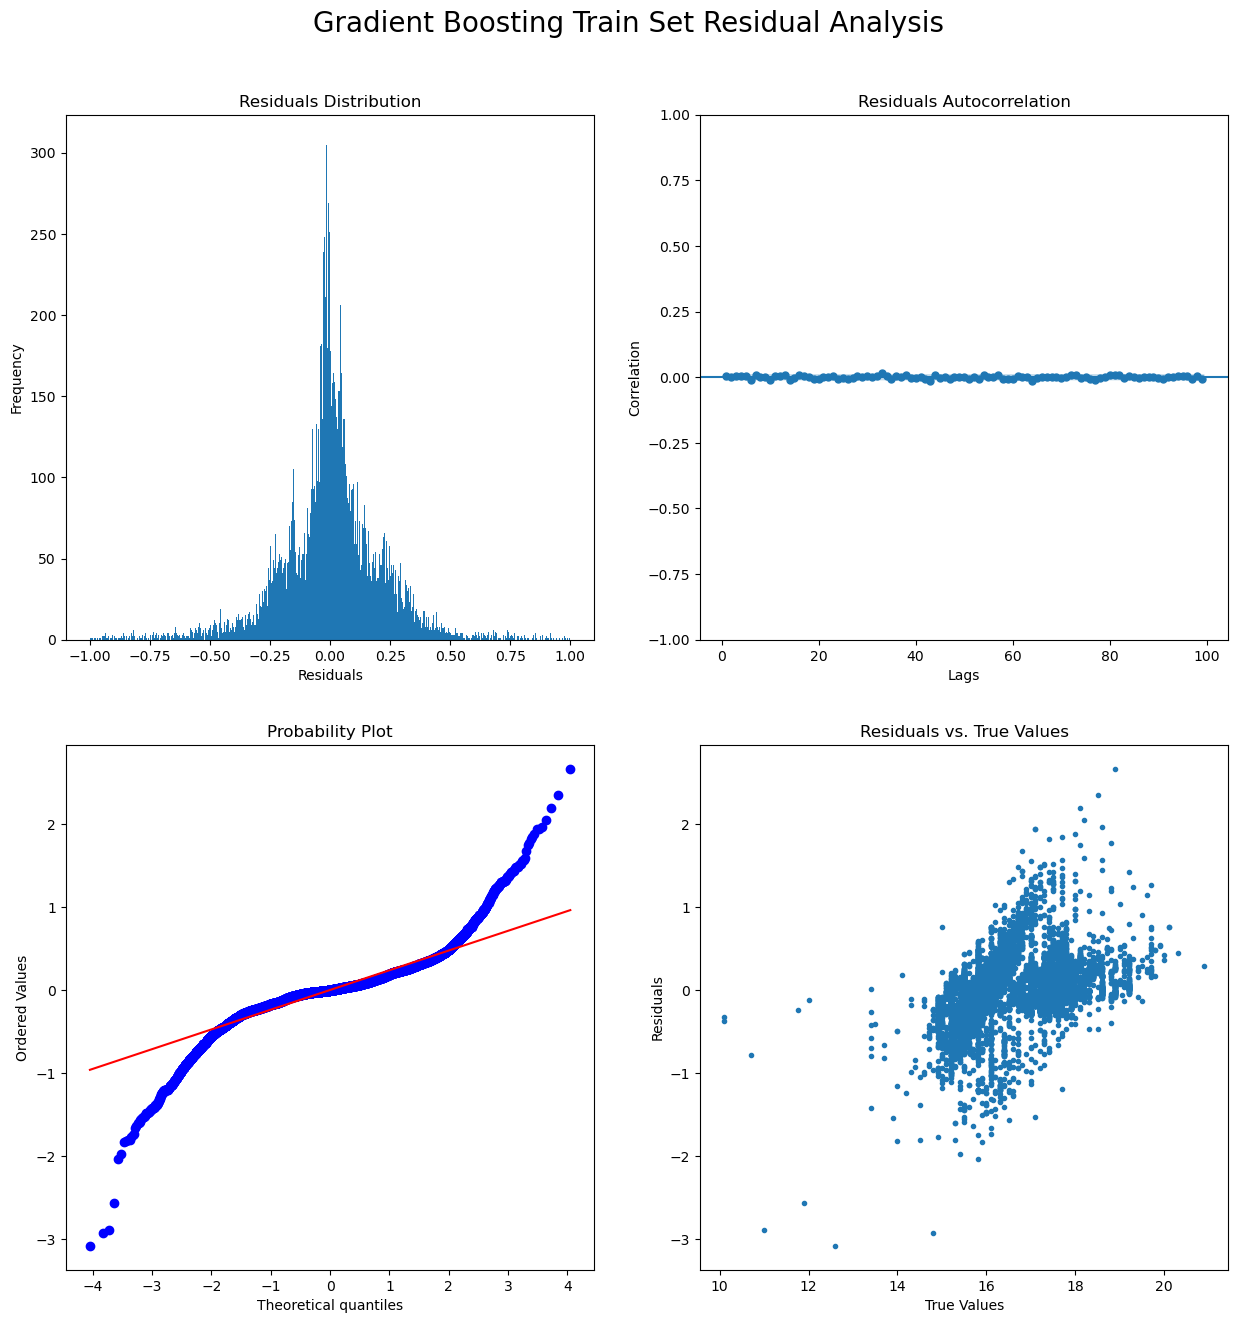

In [57]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Gradient Boosting Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-1,1))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [58]:
y_pred = np.exp(gb_model.predict(test.loc[:,formula_y.split(' + ')]))
y_true = test['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.08194803704300024
RMSE Test Set =  0.2862656756284278
MAPE Test Set =  0.010362123558952507


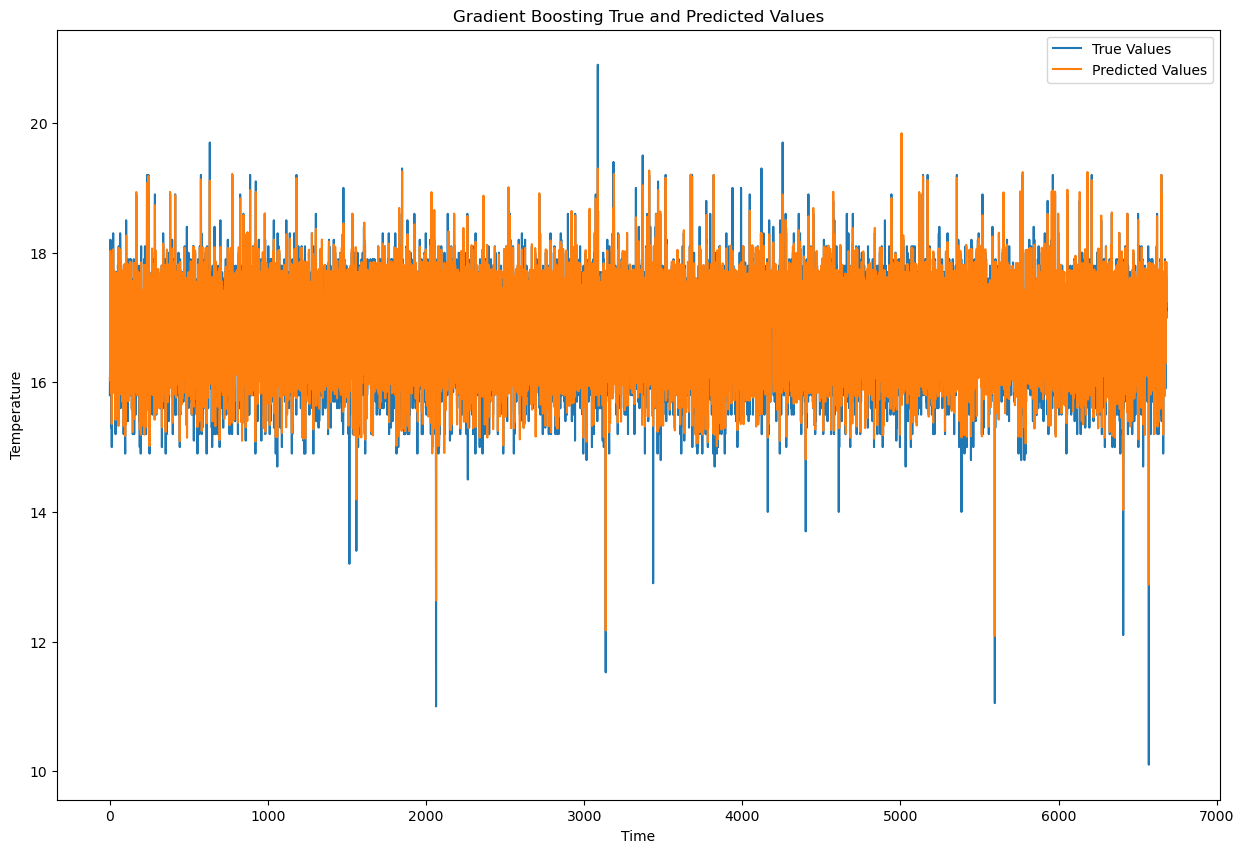

In [59]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Gradient Boosting True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

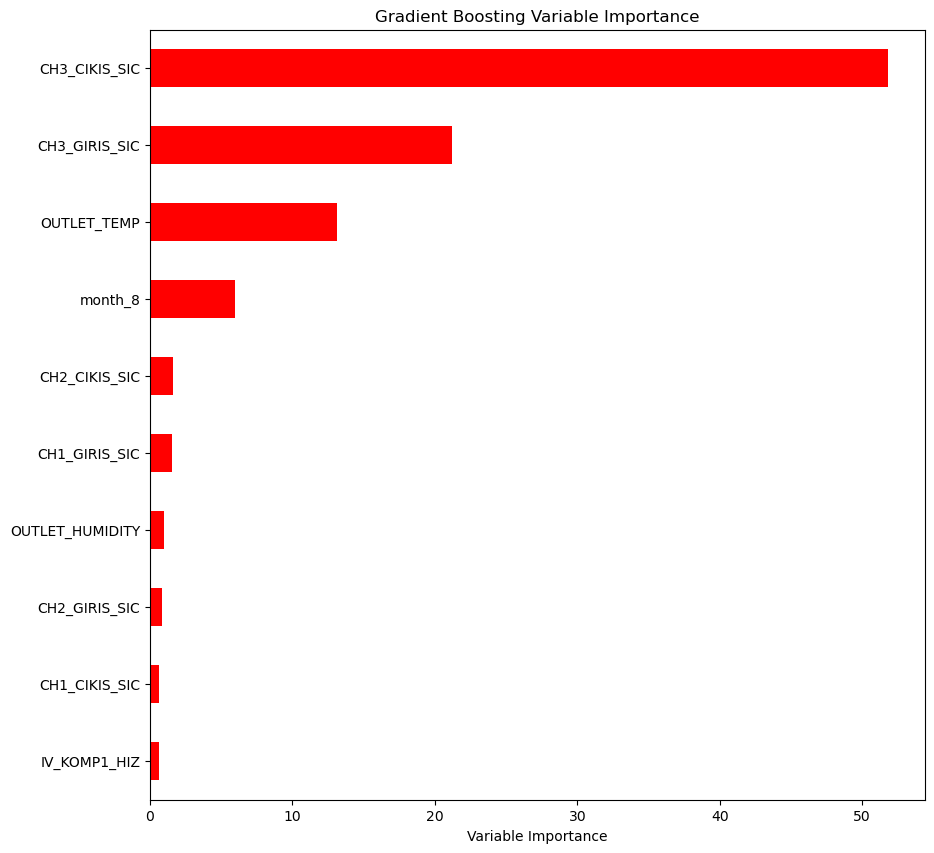

In [60]:
Importance = pd.DataFrame({'Importance':gb_model.feature_importances_*100}, 
                          )
Importance.index = train.loc[:,formula_y.split(' + ')].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(10, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Gradient Boosting Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

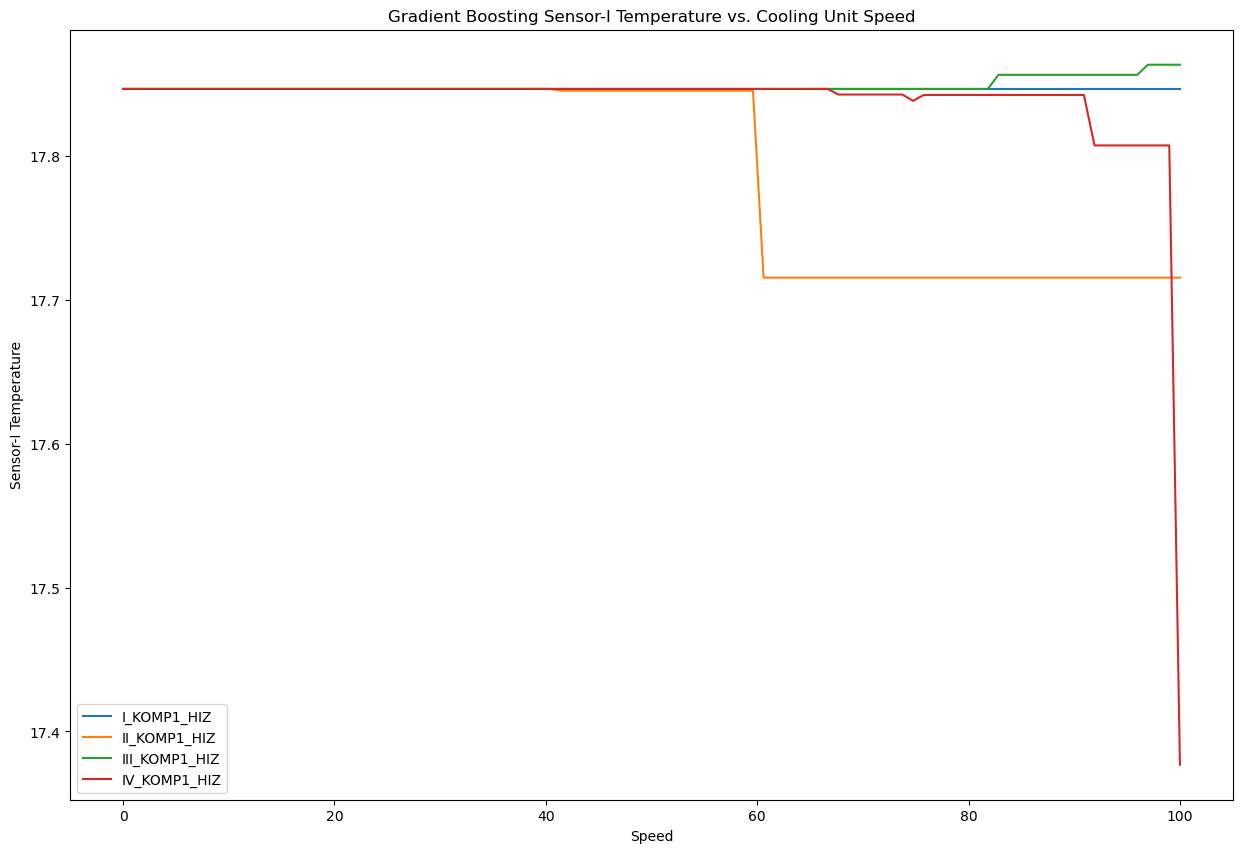

In [61]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[3][i] = y_pred
        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('Gradient Boosting Sensor-I Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-I Temperature')
plt.legend()
plt.show()

## Lasso

In [62]:
def lasso(alpha):
    lasso_result = Lasso(normalize=True)
    lasso_result.set_params(alpha = alpha)
    result = lasso_result.fit(train.loc[:,formula_y.split(" + ")], np.log(train.loc[:,"SENSOR_I_TEMP"]))
    coefs = lasso_result.coef_
    predictors = np.array((np.where(coefs != 0)[0]))
    return result, predictors

In [63]:
lasso_model, predictors = lasso(alpha=0.00002)

In [64]:
print(train.loc[:,formula_y.split(" + ")].iloc[:,list(predictors)].columns)

Index(['I_KOMP1_HIZ', 'CH2_CIKIS_SIC', 'CH3_CIKIS_SIC', 'CH3_GIRIS_SIC',
       'OUTLET_TEMP', 'OUTLET_HUMIDITY', 'month_8', 'month_10'],
      dtype='object')


In [65]:
y_pred = np.exp(lasso_model.predict(train.loc[:,formula_y.split(" + ")]))
y_true = train['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.3985427736677249
RMSE Test Set =  0.631302442310914
MAPE Test Set =  0.030125446288260114


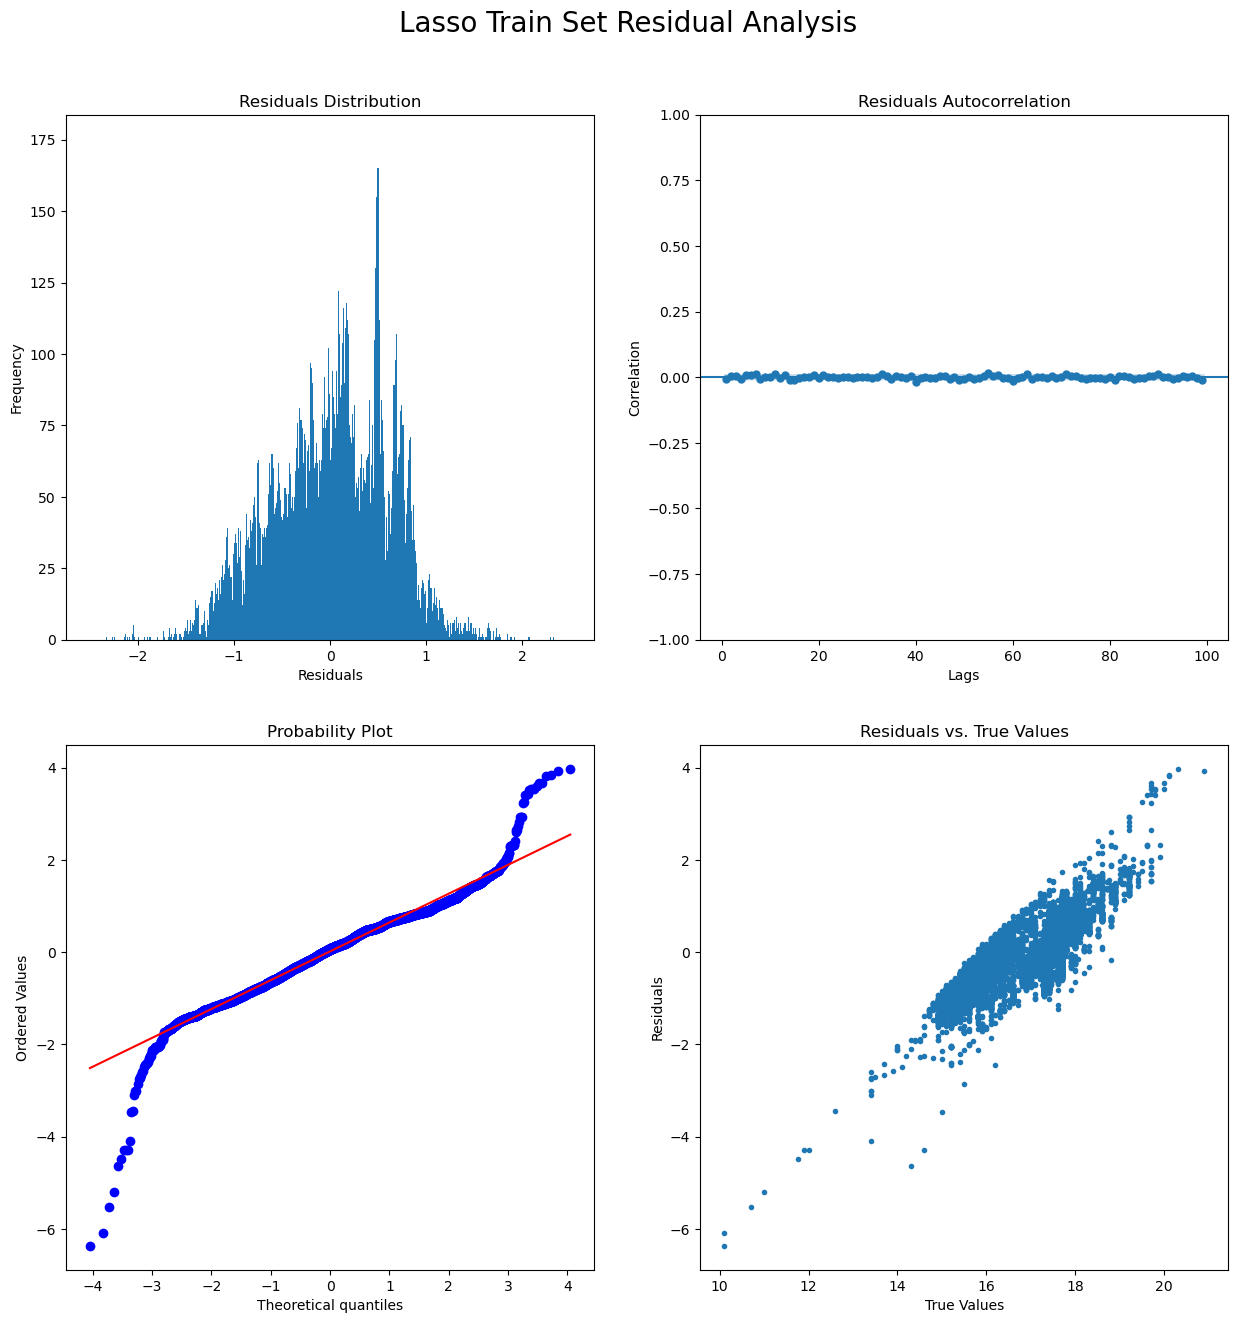

In [66]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Lasso Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-2.5,2.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [67]:
y_pred = np.exp(lasso_model.predict(test.loc[:,formula_y.split(" + ")]))
y_true = test['SENSOR_I_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.39919268146426995
RMSE Test Set =  0.6318169683256931
MAPE Test Set =  0.02985759444488732


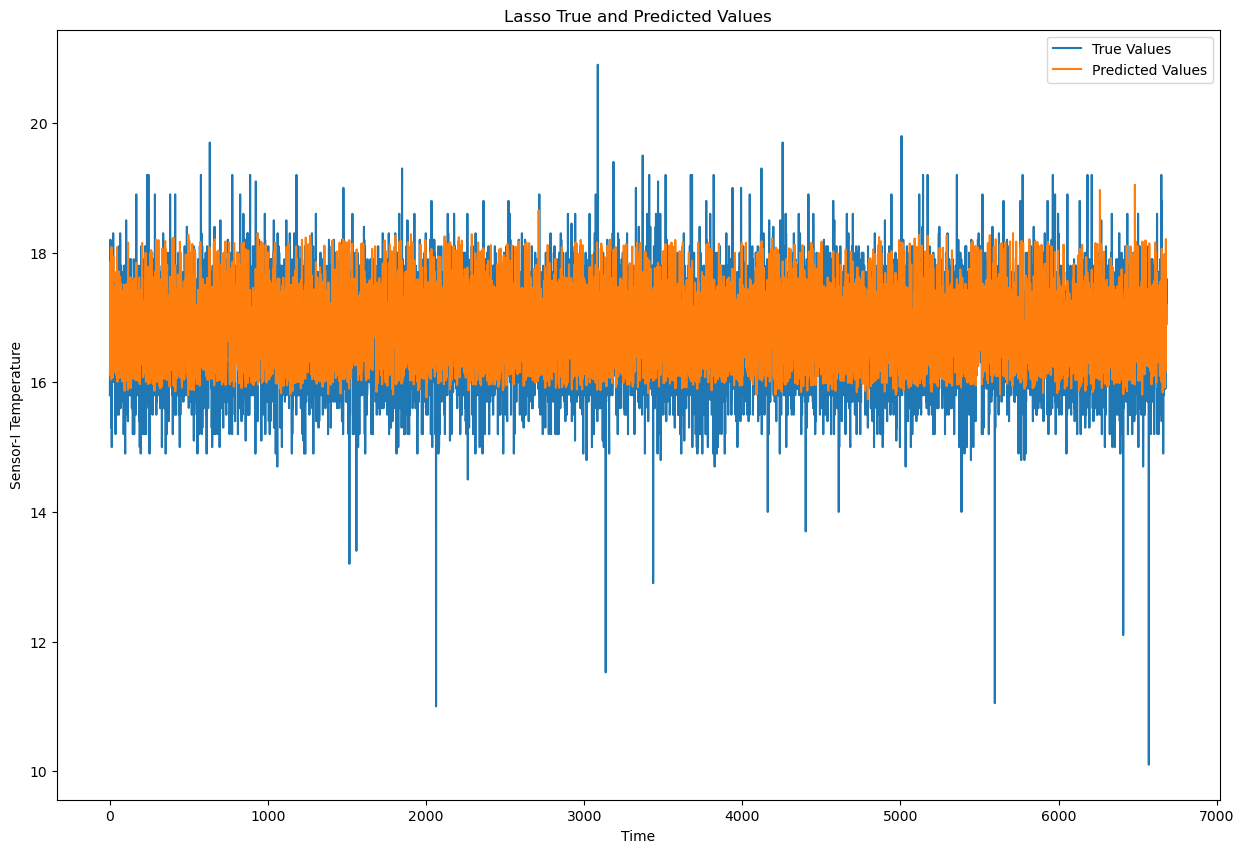

In [68]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Lasso True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Sensor-I Temperature')
plt.legend()
plt.show()

# Sensor-II Temperature Predictions

## OLS

In [69]:
reg_model = sm.ols(formula=formula2, data=train).fit()
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     np.log(SENSOR_II_TEMP)   R-squared:                       0.799
Model:                                OLS   Adj. R-squared:                  0.798
Method:                     Least Squares   F-statistic:                     2406.
Date:                    Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                            16:51:19   Log-Likelihood:                 73250.
No. Observations:                   26737   AIC:                        -1.464e+05
Df Residuals:                       26692   BIC:                        -1.460e+05
Df Model:                              44                                         
Covariance Type:                nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.9604      0.006    321.601      0.000       1.948       1.972
I_KOMP1_HIZ     -1.798e-05   9.34e-06     -1.925      0.054   -3.63e-05    3.24e-07
II_KOMP1_HIZ      1.46e-05   7.78e-06      1.877      0.061   -6.45e-07    2.99e-05
III_KOMP1_HIZ    1.606e-05   5.62e-06      2.860      0.004    5.05e-06    2.71e-05
IV_KOMP1_HIZ     -1.09e-05   8.18e-06     -1.331      0.183   -2.69e-05    5.14e-06
CH1_CIKIS_SIC      -0.0001      0.000     -1.164      0.245      -0.000       0.000
CH1_GIRIS_SIC       0.0002      0.000      1.991      0.046    3.74e-06       0.000
CH2_CIKIS_SIC       0.0005   5.04e-05      9.782      0.000       0.000       0.001
CH2_GIRIS_SIC       0.0001   1.05e-05     12.910      0.000       0.000       0.000
CH3_CIKIS_SIC       0.0005      0.000      3.986      0.000       0.000       0.001
CH3_GIRIS_SIC       0.0519      0.000    201.155      0.000       0.051       0.052
OUTLET_TEMP       6.75e-05      4e-05      1.686      0.092    -1.1e-05       0.000
OUTLET_HUMIDITY -5.009e-05   1.06e-05     -4.729      0.000   -7.08e-05   -2.93e-05
Mon                -0.0007      0.000     -2.676      0.007      -0.001      -0.000
Tue                 0.0024      0.000      9.700      0.000       0.002       0.003
Wed                -0.0007      0.000     -2.857      0.004      -0.001      -0.000
Thu                 0.0004      0.000      1.492      0.136      -0.000       0.001
Fri                 0.0002      0.000      0.883      0.377      -0.000       0.001
Sat                -0.0004      0.000     -1.618      0.106      -0.001    8.57e-05
hour_0             -0.0005      0.001     -0.966      0.334      -0.002       0.001
hour_1             -0.0006      0.001     -1.190      0.234      -0.002       0.000
hour_2             -0.0010      0.001     -1.957      0.050      -0.002    1.48e-06
hour_3             -0.0010      0.001     -1.840      0.066      -0.002    6.38e-05
hour_4             -0.0017      0.001     -3.298      0.001      -0.003      -0.001
hour_5             -0.0014      0.001     -2.808      0.005      -0.002      -0.000
hour_6             -0.0009      0.001     -1.745      0.081      -0.002       0.000
hour_7             -0.0014      0.001     -2.731      0.006      -0.002      -0.000
hour_8             -0.0010      0.001     -1.965      0.049      -0.002   -2.53e-06
hour_9              0.0032      0.001      6.138      0.000       0.002       0.004
hour_10             0.0037      0.001      6.803      0.000       0.003       0.005
hour_11             0.0023      0.001      4.295      0.000       0.001       0.003
hour_12             0.0021      0.001      3.894      0.000       0.001       0.003
hour_13            -0.0006      0.001     -1.110      0.267      -0.002       0.000
hour_14        

In [70]:
y_pred = np.exp(reg_model.predict(train))
y_true = train['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.10487615485418991
RMSE Train Set =  0.3238458813296688
MAPE Train Set =  0.005879366022339156


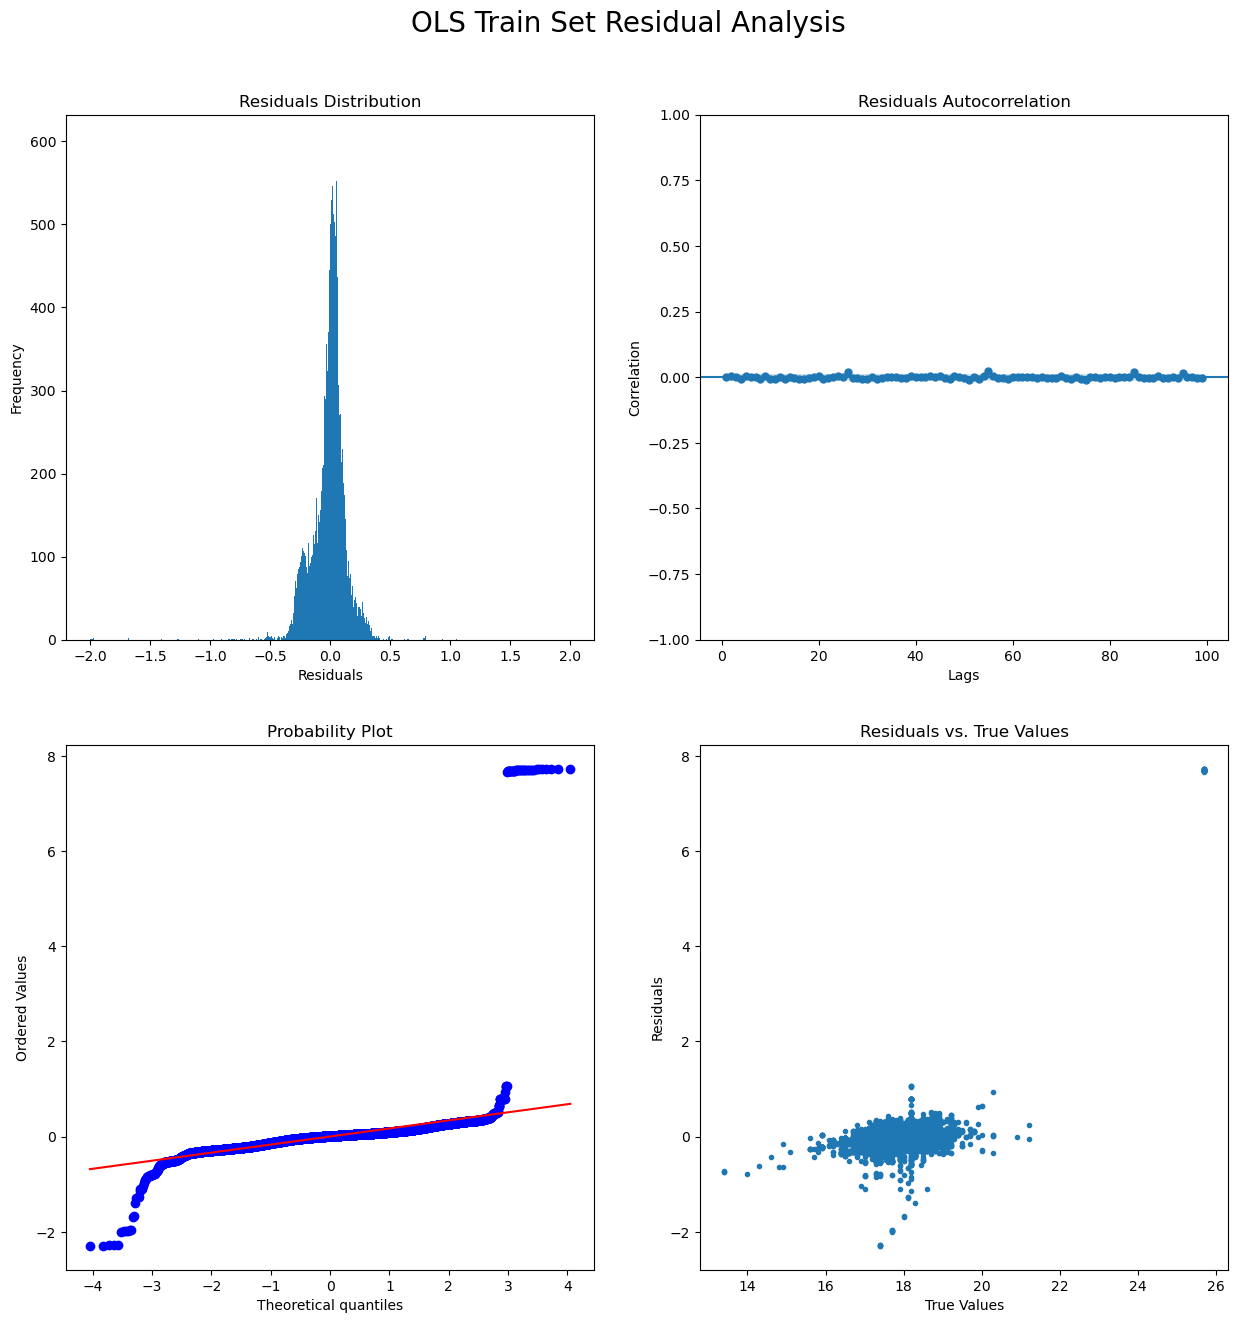

In [71]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('OLS Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-2,2))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [72]:
y_pred = np.exp(reg_model.predict(test))
y_true = test['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.07551553862890463
RMSE Test Set =  0.27480090725633466
MAPE Test Set =  0.005877835768003067


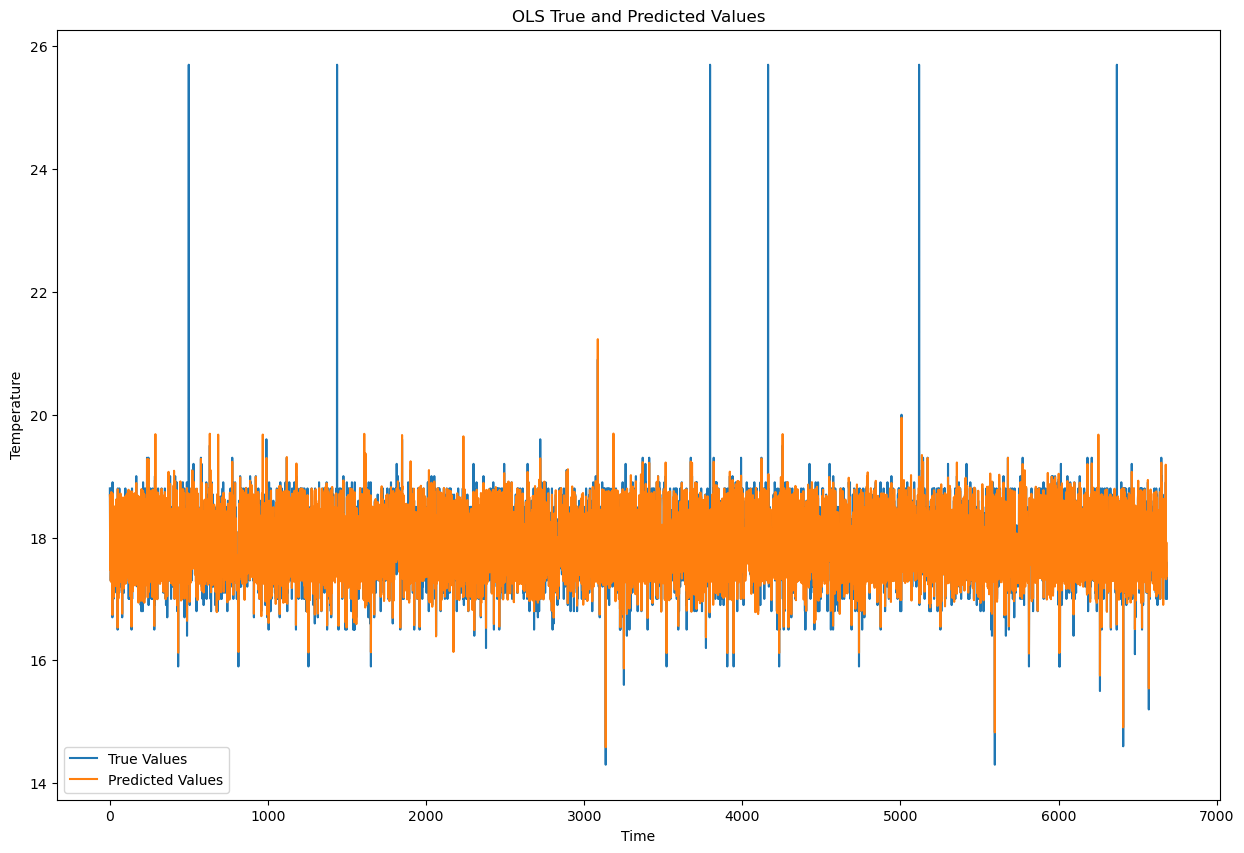

In [73]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(list(y_pred), label='Predicted Values')
plt.title('OLS True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

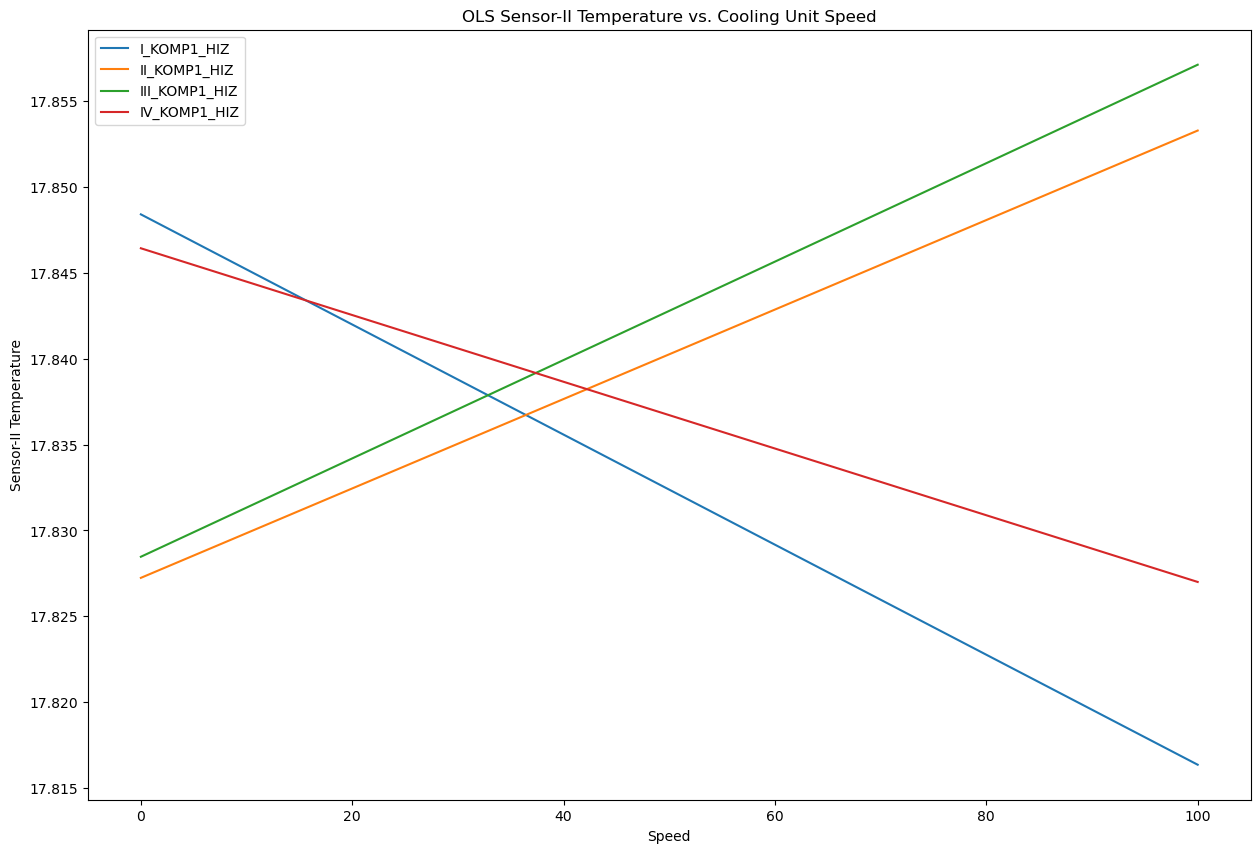

In [74]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((8,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(reg_model.predict(temp_df))
    Y[3][i] = y_pred

        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('OLS Sensor-II Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-II Temperature')
plt.legend()
plt.show()

## Random Forest

In [75]:
def random_forest(max_features):
    random_forest = RandomForestRegressor(random_state=23, max_features=max_features)
    result = random_forest.fit(train.loc[:,formula_y.split(' + ')], np.log(train.loc[:,"SENSOR_II_TEMP"]))
    return result

In [76]:
rf_model = random_forest(max_features='sqrt')

In [77]:
y_pred = np.exp(rf_model.predict(train.loc[:,formula_y.split(' + ')]))
y_true = train['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.0026065880876599587
RMSE Train Set =  0.05105475577906488
MAPE Train Set =  0.0015673918029093425


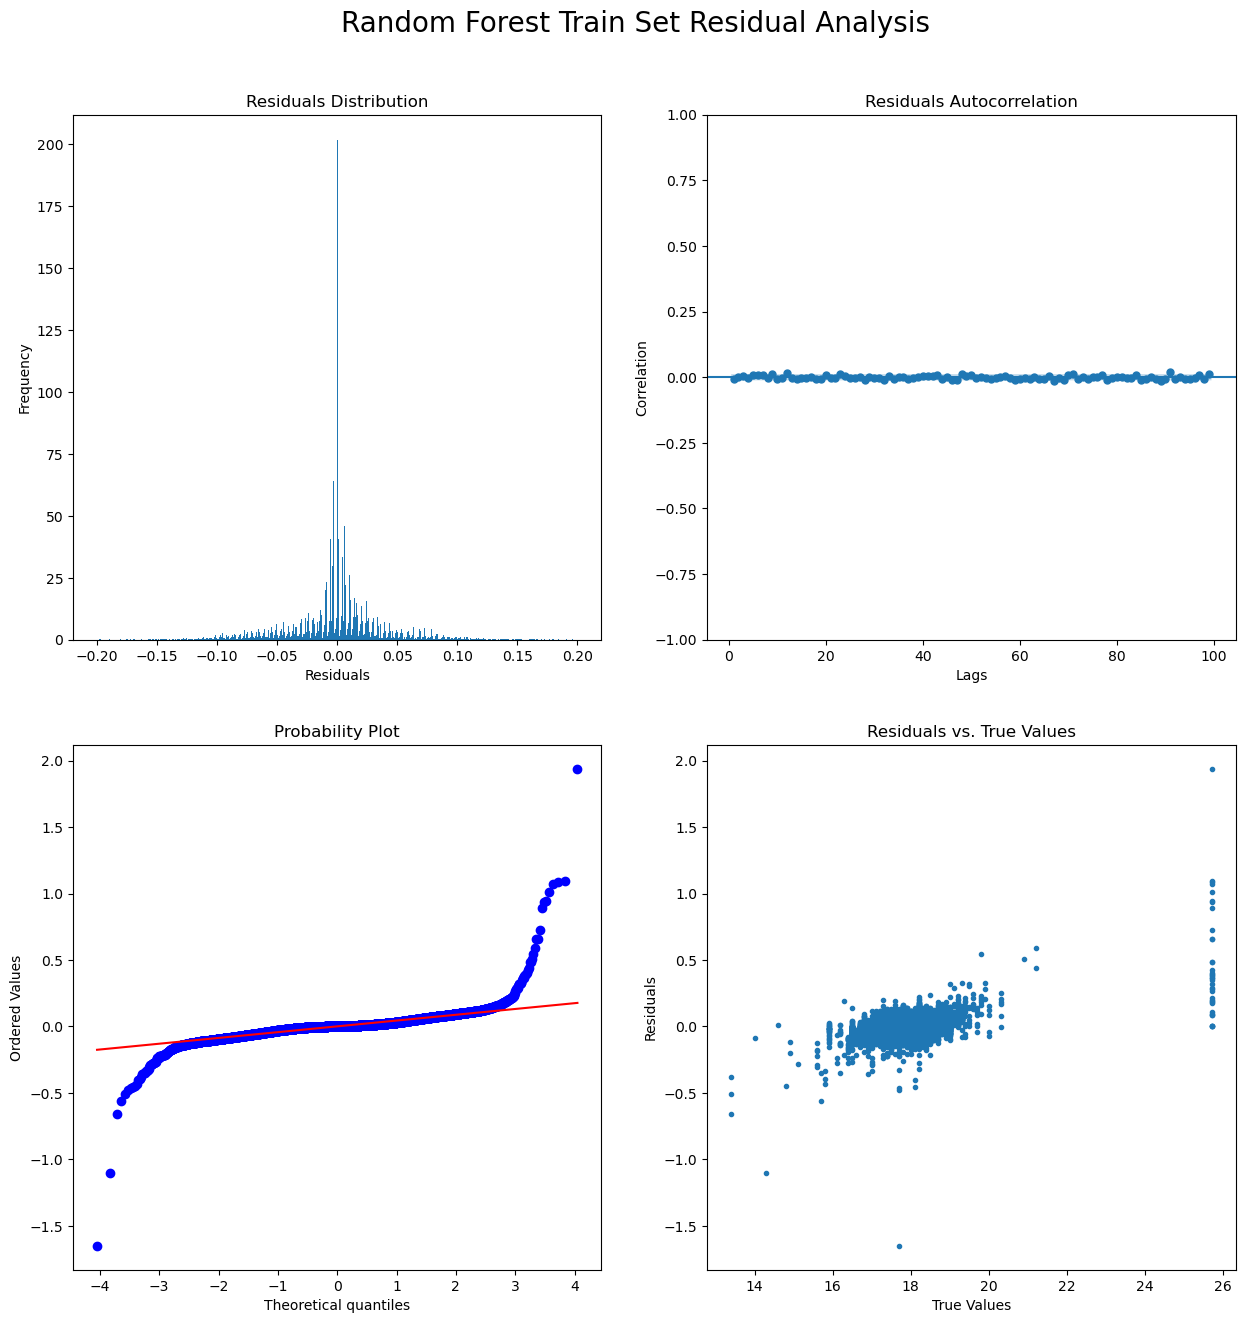

In [78]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Random Forest Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.2,0.2), density=True)
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [79]:
y_pred = np.exp(rf_model.predict(test.loc[:,formula_y.split(' + ')]))
y_true = test['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.013901887646521912
RMSE Test Set =  0.11790626635816229
MAPE Test Set =  0.004051526445064988


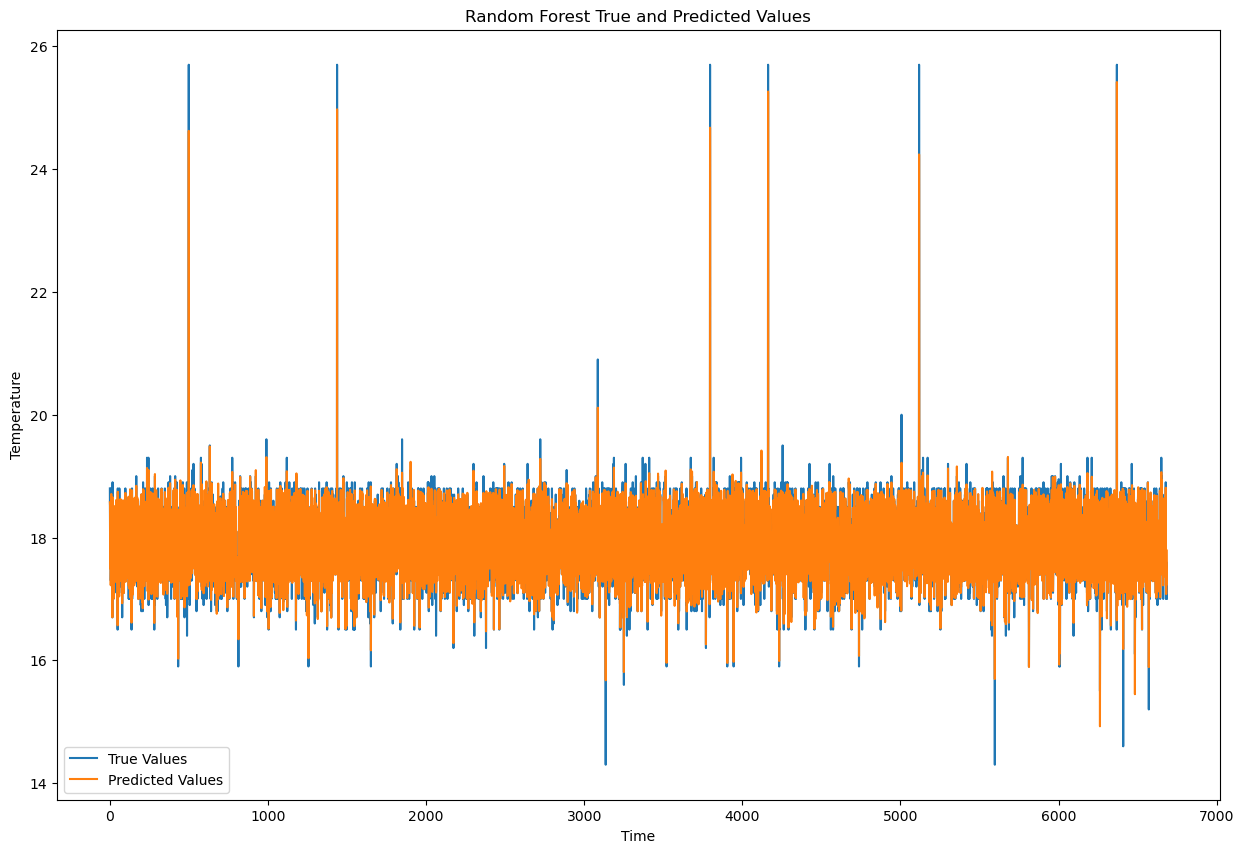

In [80]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Random Forest True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

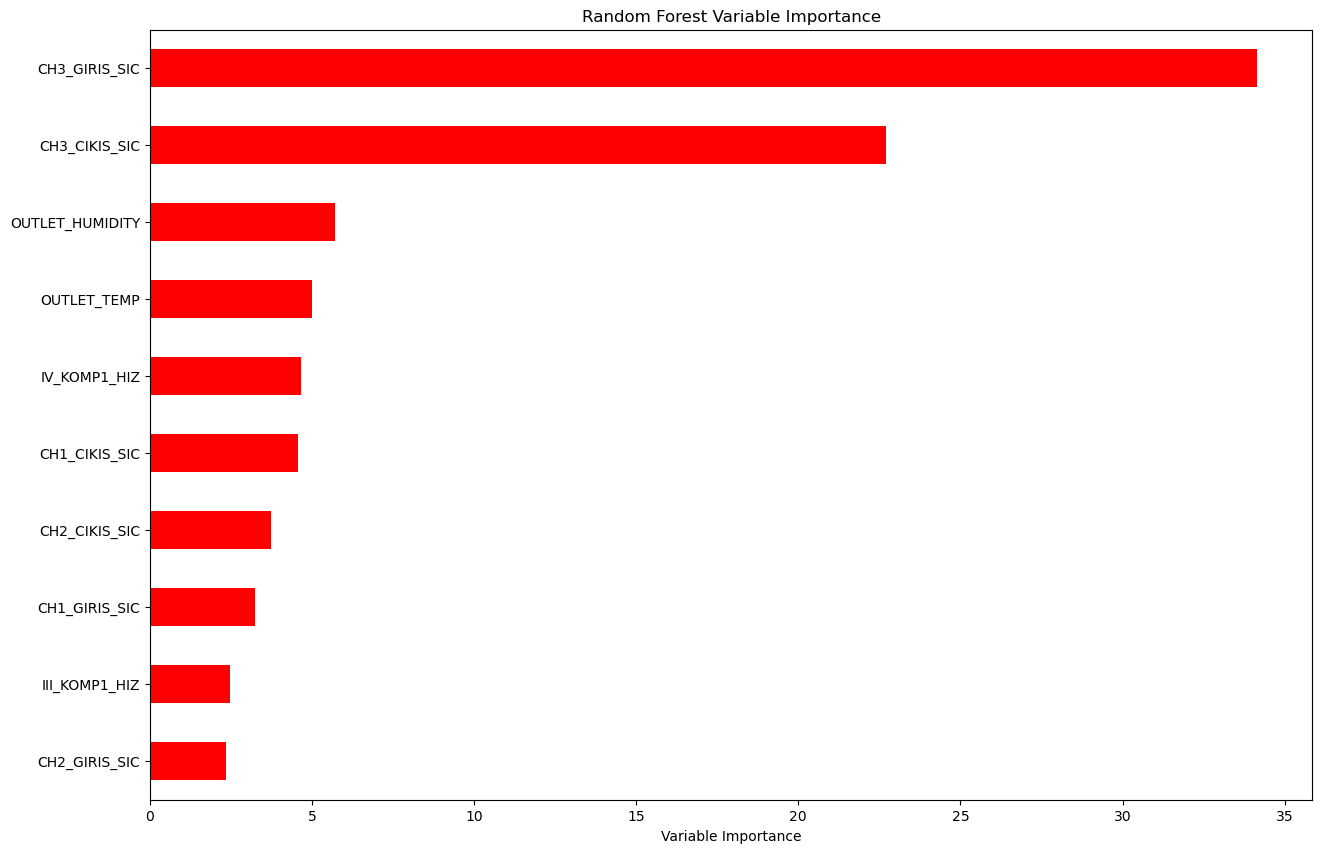

In [81]:
Importance = pd.DataFrame({'Importance':rf_model.feature_importances_*100}, 
                          )
Importance.index = train.loc[:,formula_y.split(' + ')].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(15, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Random Forest Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

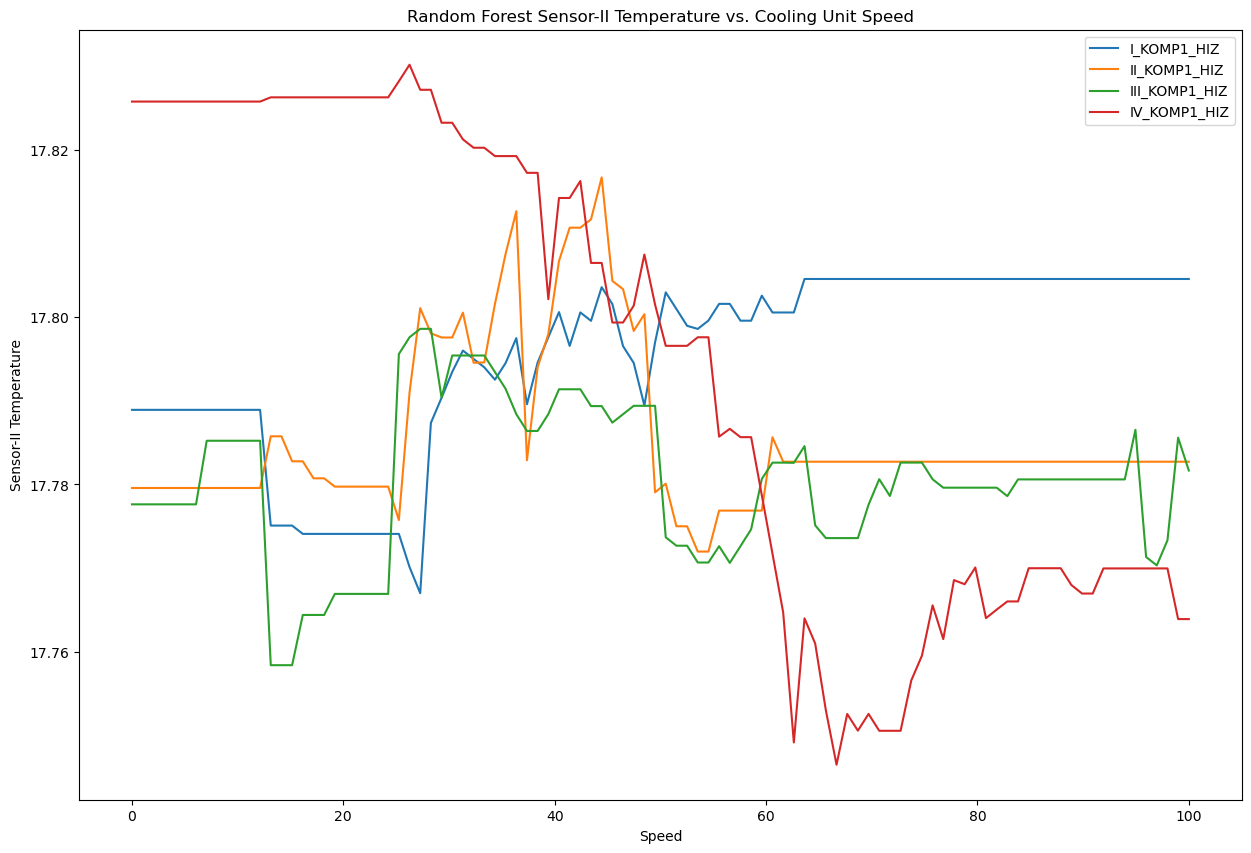

In [82]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(rf_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[3][i] = y_pred


        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('Random Forest Sensor-II Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-II Temperature')
plt.legend()
plt.show()

## Gradient Boosting

In [83]:
def gradient_boosting(depth, lr):
    gb = GradientBoostingRegressor(random_state=23, learning_rate=lr, max_depth=depth)
    result = gb.fit(train.loc[:,formula_y.split(' + ')], np.log(train.loc[:,"SENSOR_II_TEMP"]))
    return result

In [84]:
gb_model = gradient_boosting(lr=0.1, depth=5)

In [85]:
y_pred = np.exp(gb_model.predict(train.loc[:,formula_y.split(' + ')]))
y_true = train['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetrain = np.mean(np.square(residuals))
rmsetrain= np.sqrt(msetrain)
mapetrain = np.mean(np.abs(residuals)/y_true)
print('MSE Train Set = ', msetrain)
print('RMSE Train Set = ', rmsetrain)
print('MAPE Train Set = ', mapetrain)

MSE Train Set =  0.010626072810839455
RMSE Train Set =  0.10308284440603807
MAPE Train Set =  0.003948689939453983


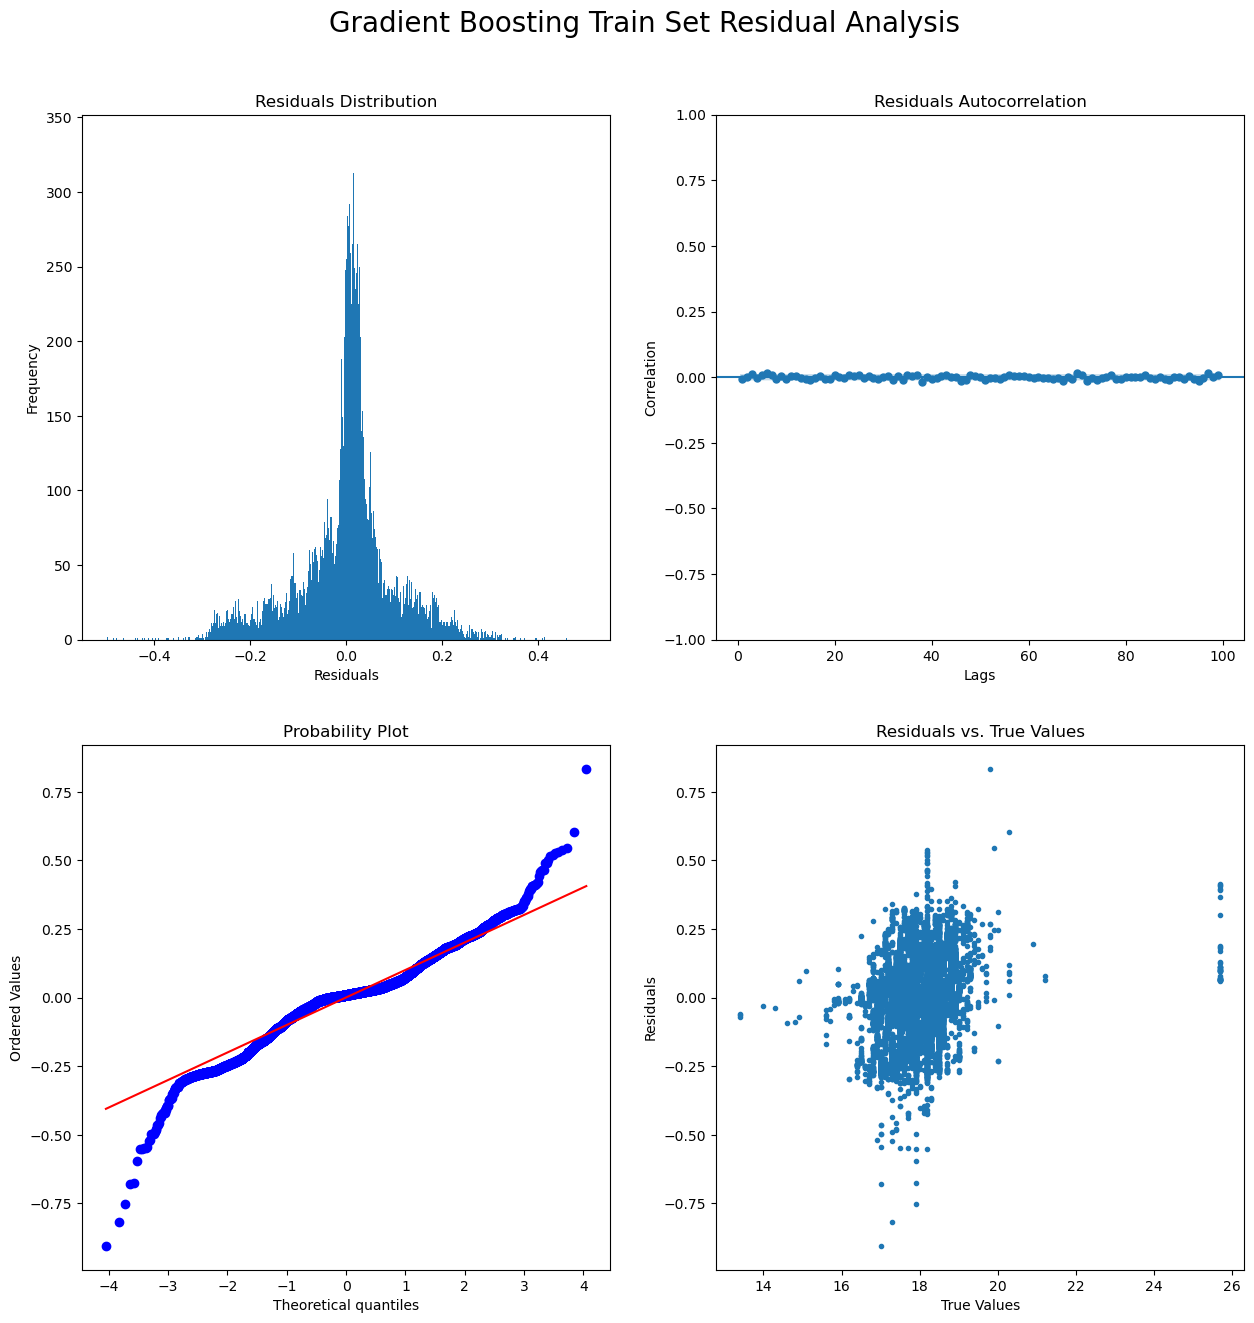

In [86]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Gradient Boosting Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.5,0.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [87]:
y_pred = np.exp(gb_model.predict(test.loc[:,formula_y.split(' + ')]))
y_true = test['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.012475815688885285
RMSE Test Set =  0.1116951909837003
MAPE Test Set =  0.0041439838222249005


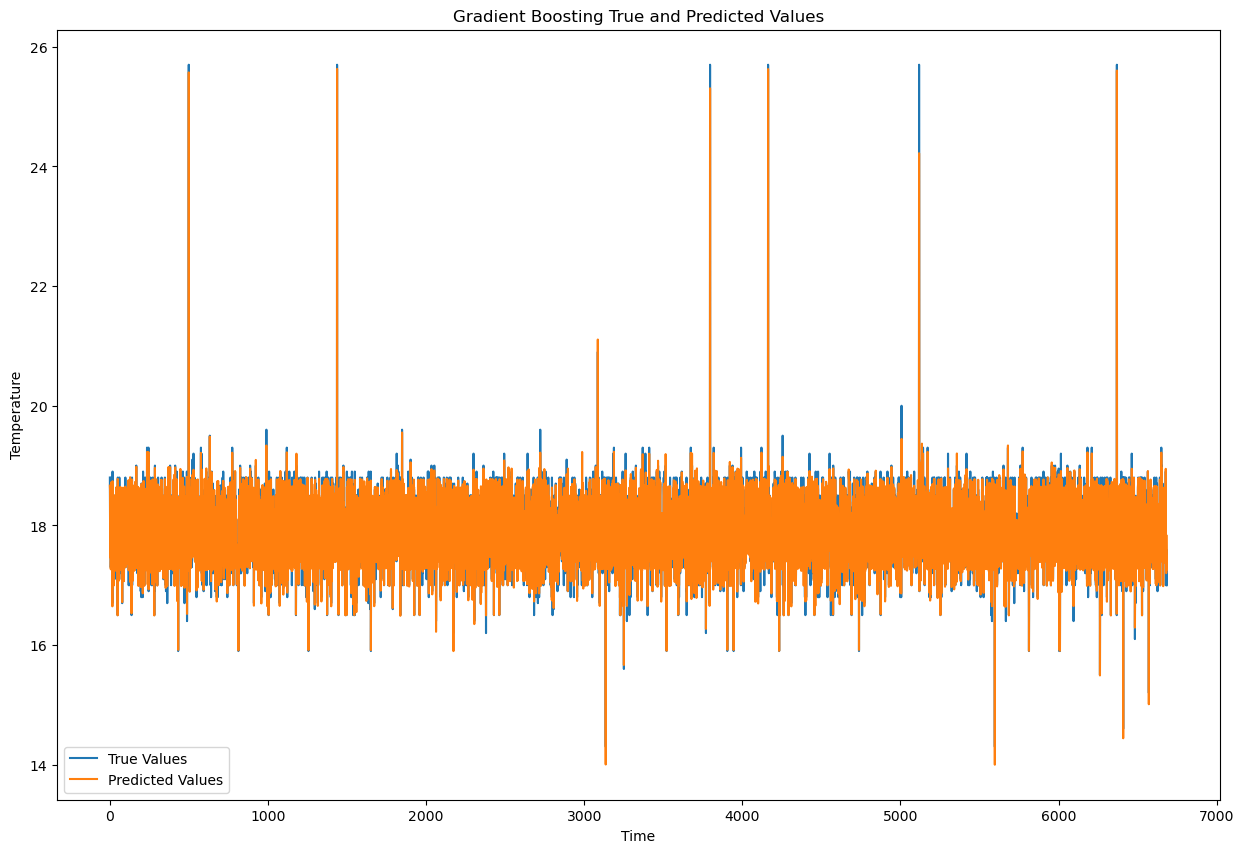

In [88]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Gradient Boosting True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

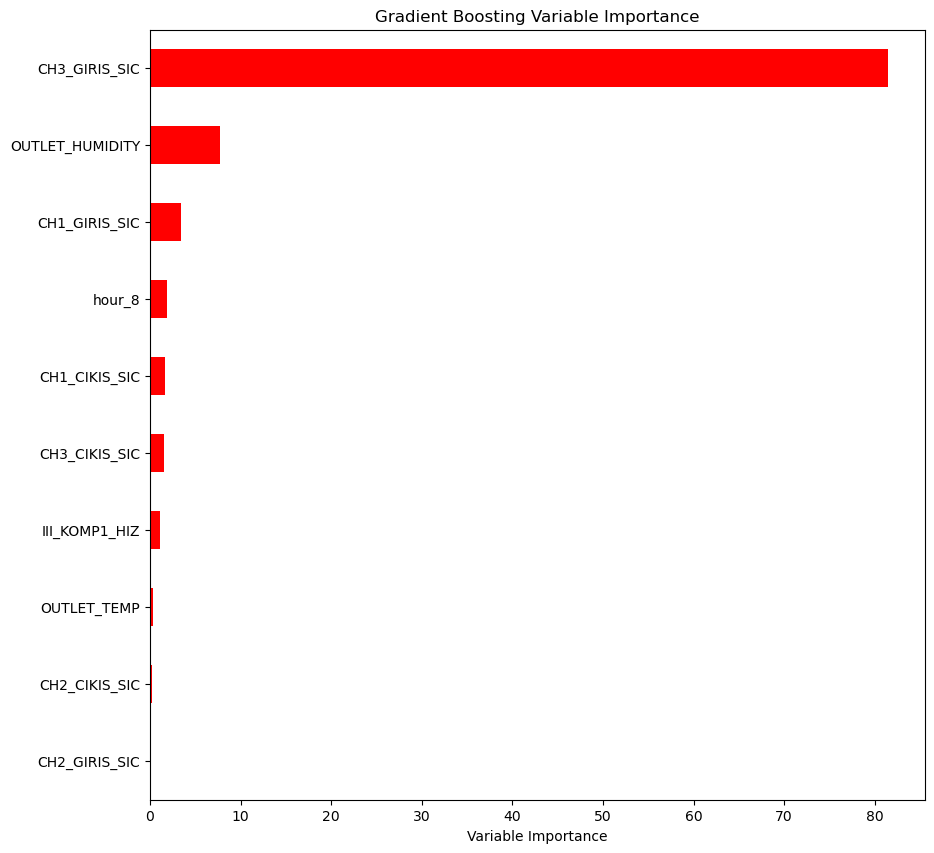

In [89]:
Importance = pd.DataFrame({'Importance':gb_model.feature_importances_*100}, 
                          )
Importance.index = train.loc[:,formula_y.split(' + ')].columns
Importance = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)

fig, ax = plt.subplots(figsize=(10, 10))
Importance.iloc[-10:].plot(kind = 'barh', 
                color = 'r',
                ax = ax)
plt.title("Gradient Boosting Variable Importance")
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

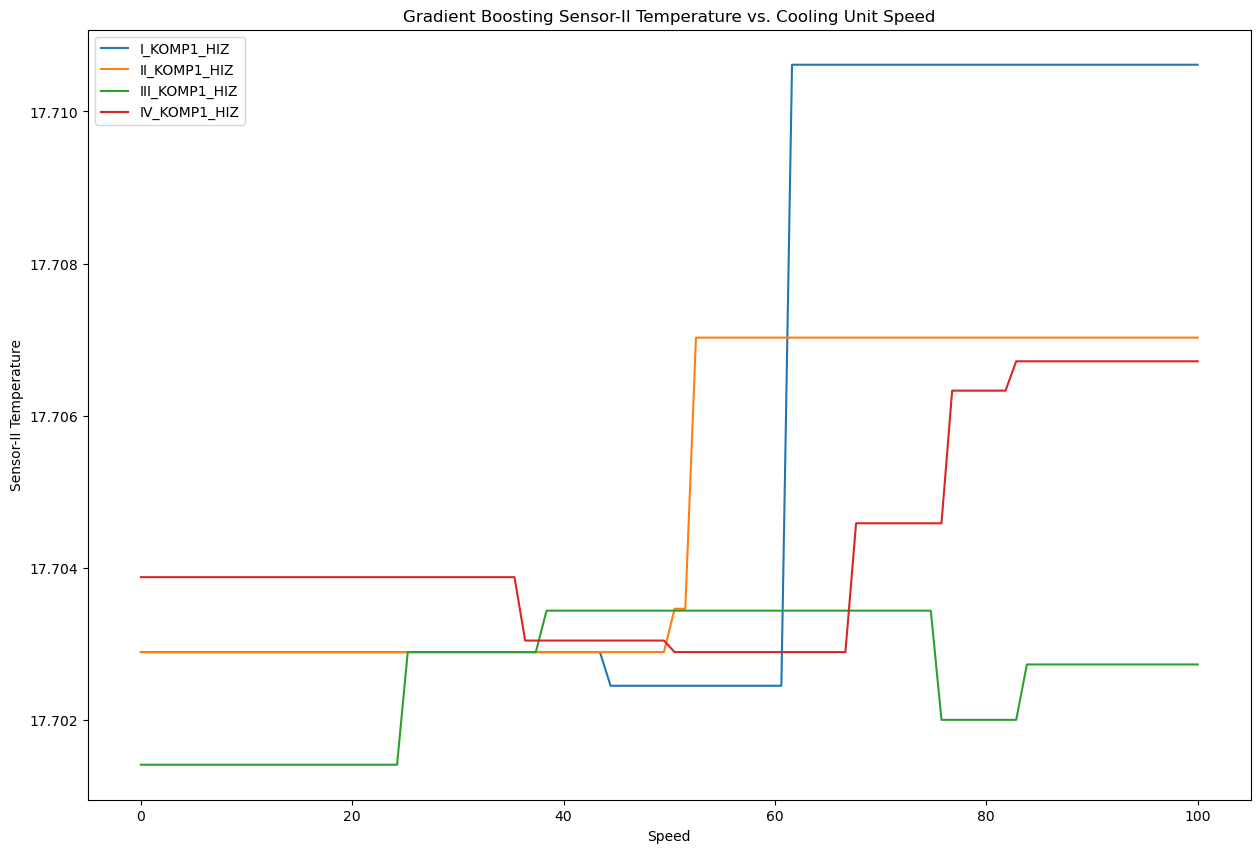

In [90]:
## 1000 numbers with same space between 0 and 100
x = np.linspace(0,100,100)
Y = np.zeros((4,len(x)))
for i,val in enumerate(x):
    temp_df = pd.DataFrame(train.mean()).T
    temp_df['I_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[0][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['II_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[1][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['III_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[2][i] = y_pred

    temp_df = pd.DataFrame(train.mean()).T
    temp_df['IV_KOMP1_HIZ'] = val
    ## predict
    y_pred = np.exp(gb_model.predict(temp_df.loc[:,formula_y.split(" + ")]))
    Y[3][i] = y_pred


        
## plot x and Y
plt.figure(figsize=(15,10))
plt.plot(x,Y[0], label='I_KOMP1_HIZ')
plt.plot(x,Y[1], label='II_KOMP1_HIZ')
plt.plot(x,Y[2], label='III_KOMP1_HIZ')
plt.plot(x,Y[3], label='IV_KOMP1_HIZ')
plt.title('Gradient Boosting Sensor-II Temperature vs. Cooling Unit Speed')
plt.xlabel('Speed')
plt.ylabel('Sensor-II Temperature')
plt.legend()
plt.show()

## Lasso

In [91]:
def lasso(alpha):
    lasso_result = Lasso(normalize=True)
    lasso_result.set_params(alpha = alpha)
    result = lasso_result.fit(train.loc[:,formula_y.split(" + ")], np.log(train.loc[:,"SENSOR_II_TEMP"]))
    coefs = lasso_result.coef_
    predictors = np.array((np.where(coefs != 0)[0]))
    return result, predictors

In [92]:
lasso_model, predictors = lasso(alpha=0.00002)

In [93]:
print(train.loc[:,formula_y.split(" + ")].iloc[:,list(predictors)].columns)

Index(['CH3_GIRIS_SIC'], dtype='object')


In [94]:
y_pred = np.exp(lasso_model.predict(train.loc[:,formula_y.split(" + ")]))
y_true = train['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.11148609440667984
RMSE Test Set =  0.33389533450870473
MAPE Test Set =  0.006133244622695467


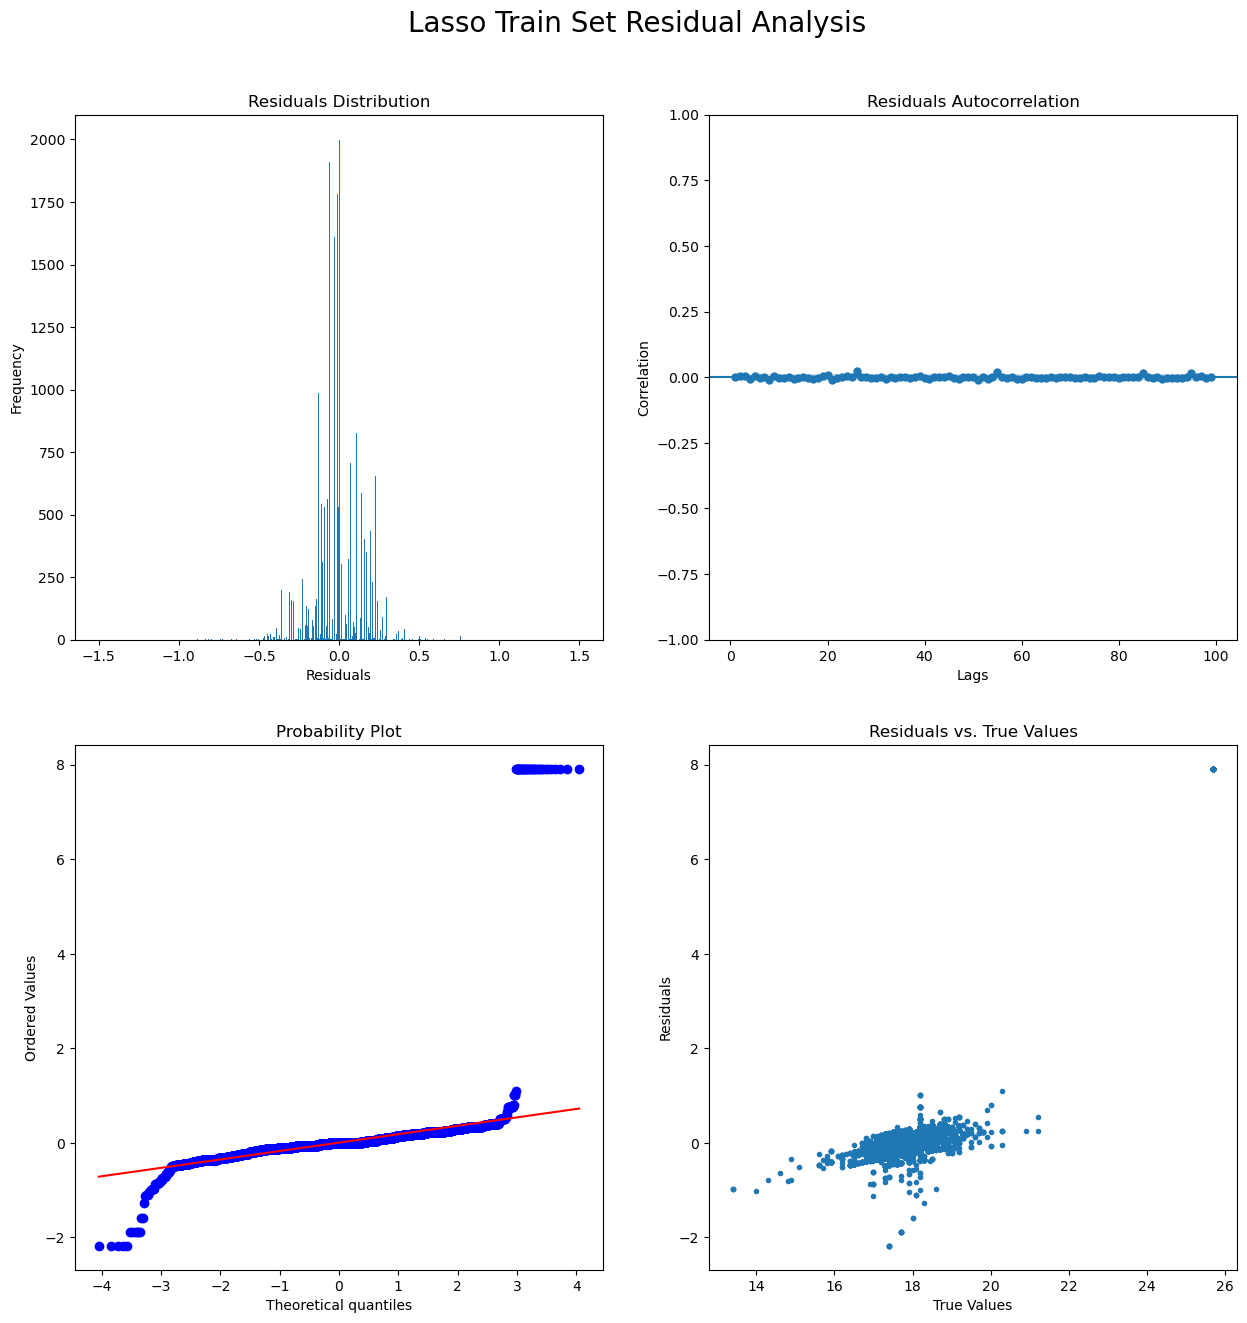

In [95]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Lasso Train Set Residual Analysis', fontsize=20, y=0.95)
axes[0,0].hist(residuals, bins=1000, range=(-0.5,0.5))
axes[0,0].set_title('Residuals Distribution')
axes[0,0].set_xlabel('Residuals')
axes[0,0].set_ylabel('Frequency')
## residual autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=range(1,100), ax=axes[0,1])
axes[0,1].set_title('Residuals Autocorrelation')
axes[0,1].set_xlabel('Lags')
axes[0,1].set_ylabel('Correlation')
# plot qq plot
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=axes[1,0])
## plot residuals
axes[1,1].plot(y_true, residuals, '.')
axes[1,1].set_title('Residuals vs. True Values')
axes[1,1].set_xlabel('True Values')
axes[1,1].set_ylabel('Residuals')
plt.show()

In [96]:
y_pred = np.exp(lasso_model.predict(test.loc[:,formula_y.split(" + ")]))
y_true = test['SENSOR_II_TEMP']
residuals = y_true - y_pred
msetest = np.mean(np.square(residuals))
rmsetest= np.sqrt(msetest)
mapetest = np.mean(np.abs(residuals)/y_true)
print('MSE Test Set = ', msetest)
print('RMSE Test Set = ', rmsetest)
print('MAPE Test Set = ', mapetest)

MSE Test Set =  0.0800704460697956
RMSE Test Set =  0.2829672173058137
MAPE Test Set =  0.00609514450836929


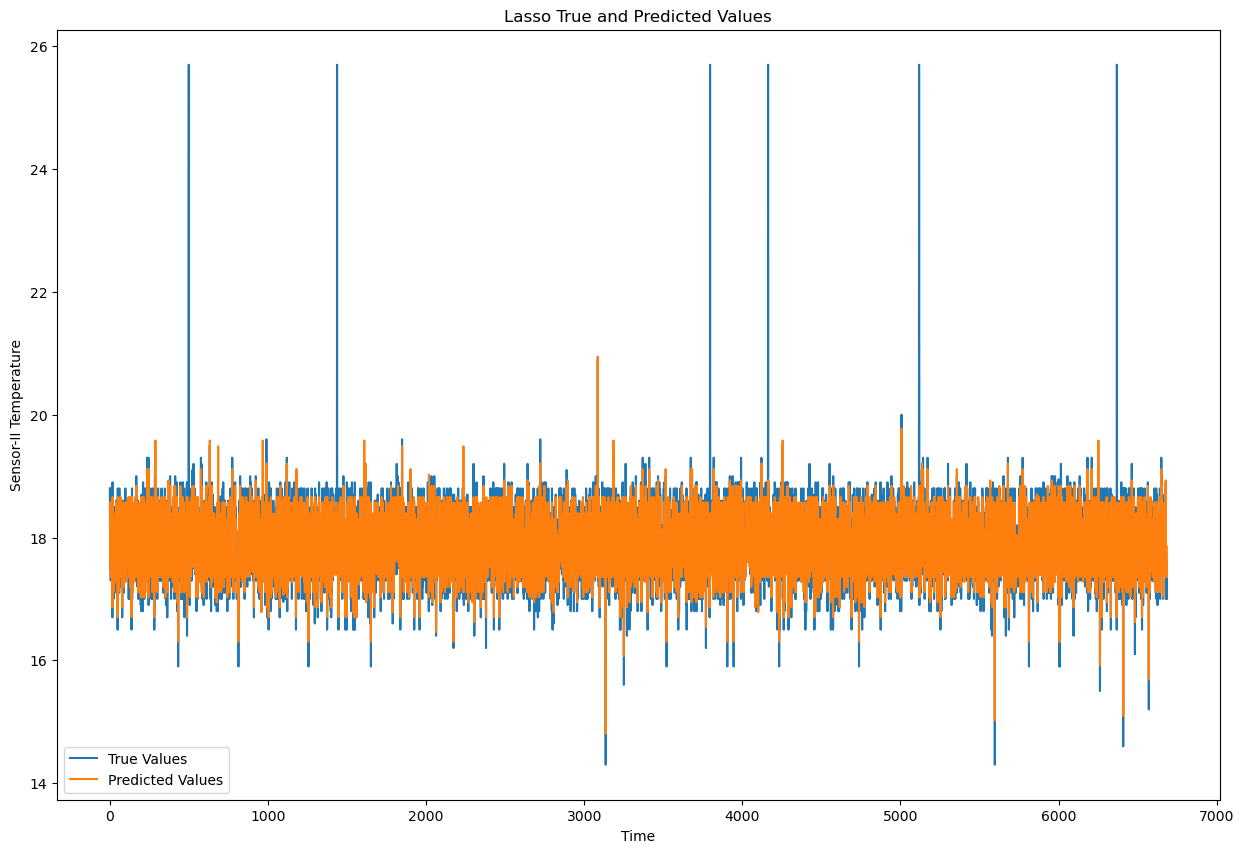

In [97]:
## plot estimated and true values
plt.figure(figsize=(15,10))
plt.plot(list(y_true), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Lasso True and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Sensor-II Temperature')
plt.legend()
plt.show()